### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from config import plot_config
from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig
from preprocessing.outliers import replace_outliers_iqr
from utils.utils import (print_numerical_features_range, evaluate_model, evaluate_all_models,
                         analyze_null_values, impute_missing_values, train_valid_split, remove_negative_values,
                         apply_feature_engineering, save_processed_data, calculate_class_weights, normalize_data,
                         process_training_data,evaluate_model)

from utils.visuals import (analyze_categorical_variables, plot_lambda_tuning, plot_data_analysis_all_visualizations )
from models.logistic_regression import LogisticRegression, LogisticRegressionConfig
from evaluation.cross_validation import cross_validate_lambda
from evaluation.metrics import f1_score
from models.logistic_regression import LogisticRegression, LogisticRegressionConfig

from preprocessing.data_loader import DataLoader, DatasetConfig, SplitConfig
from preprocessing.rebalancing import (
    RandomUnderSampler, 
    RandomOverSampler, 
    SMOTE, 
    SMOTEConfig,
    RebalancingConfig
)



### Configuración de Directorios y Variables Globales

In [2]:
fig_output_dir_p1 = "../figures/p1"
os.makedirs(fig_output_dir_p1, exist_ok=True)
fig_output_dir_p2 = "../figures/p2"
os.makedirs(fig_output_dir_p2, exist_ok=True)

current_dir = Path.cwd()
data_dir = current_dir.parent / "data"
data_dir = data_dir.resolve()
data_dir_p1 = data_dir / "p1"
data_dir_p2 = data_dir / "p2"

# Punto 1.1: Inicialización del Dataset

In [3]:
config_cell_diagnosis = DatasetConfig(
    data_dir=data_dir_p1,
    target_column="Diagnosis",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)
loader_cell_diagnosis = DataLoader(config_cell_diagnosis)
loader_cell_diagnosis.read_data(
    dev_file="raw/cell_diagnosis_balanced_dev.csv",
    test_file="raw/cell_diagnosis_balanced_test.csv",
    splitted=False
)
cell_diagnosis_balanced_dev_outliers, cell_diagnosis_balanced_test_outliers = loader_cell_diagnosis.get_pandas_data(splitted=False)

### Análisis de Valores Nulos y División Train/Valid

In [4]:
cell_diagnosis_balanced_for_train_outliers, cell_diagnosis_balanced_for_valid_outliers = train_valid_split(
    cell_diagnosis_balanced_dev_outliers, test_size=0.2, random_state=42
)

analyze_null_values(
    [cell_diagnosis_balanced_for_train_outliers, cell_diagnosis_balanced_test_outliers],
    ["conjunto de train", "conjunto de prueba"]
);

Valores nulos en conjunto de train:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                258           19.38
1             CellShape                258           19.38
2        NucleusDensity                235           17.66
3      ChromatinTexture                239           17.96
4         CytoplasmSize                241           18.11
5          CellAdhesion                242           18.18
6           MitosisRate                252           18.93
7       NuclearMembrane                262           19.68
8          GrowthFactor                235           17.66
9      OxygenSaturation                228           17.13
10      Vascularization                234           17.58
11  InflammationMarkers                243           18.26
12            Diagnosis                  0            0.00
13             CellType                192           14.43
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo      1228           92.26
1           Muestras sin valores nulos       103            7.74
2                    Total de muestras      1331          100.00



Valores nulos en conjunto de prueba:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                 35           18.92
1             CellShape                 41           22.16
2        NucleusDensity                 32           17.30
3      ChromatinTexture                 35           18.92
4         CytoplasmSize                 33           17.84
5          CellAdhesion                 29           15.68
6           MitosisRate                 36           19.46
7       NuclearMembrane                 25           13.51
8          GrowthFactor                 40           21.62
9      OxygenSaturation                 31           16.76
10      Vascularization                 40           21.62
11  InflammationMarkers                 36           19.46
12            Diagnosis                  0            0.00
13             CellType                 31           16.76
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       172           92.97
1           Muestras sin valores nulos        13            7.03
2                    Total de muestras       185          100.00

### Separamos el dataset para el cross validation, ya que para cada fold se realiza un preprocesamiento distinto

In [5]:
X_train_cell_diagnosis_balanced_for_cross_validation = cell_diagnosis_balanced_for_train_outliers.drop(columns=["Diagnosis"])

y_train_cell_diagnosis_balanced_for_cross_validation = cell_diagnosis_balanced_for_train_outliers["Diagnosis"]


### Imputación de Valores Faltantes

In [6]:
cell_diagnosis_balanced_for_train_outliers, cell_diagnosis_balanced_for_valid_outliers, cell_diagnosis_balanced_test_outliers = impute_missing_values(
    cell_diagnosis_balanced_for_train_outliers,
    cell_diagnosis_balanced_for_valid_outliers,
    cell_diagnosis_balanced_test_outliers,
    knn_neighbors=8,
    knn_weights="distance"
)

Missing values before imputation:
Train: 3119 missing values
Valid: 844 missing values
Test: 444 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


### Análisis de Rango de Features

In [7]:
print_numerical_features_range(cell_diagnosis_balanced_for_train_outliers)

Feature    Mínimo     Máximo
0              CellSize -100.0000  1000.0000
1             CellShape   -0.9239     5.0486
2        NucleusDensity   -3.0000    50.0000
3      ChromatinTexture   10.0000   263.7934
4         CytoplasmSize    5.0000   299.3506
5          CellAdhesion   -4.4618     5.0299
6           MitosisRate   -5.0000   100.0000
7       NuclearMembrane   -3.4390    24.6463
8          GrowthFactor  -50.0000   563.6227
9      OxygenSaturation  -10.0000   777.4346
10      Vascularization   -0.9971    54.5124
11  InflammationMarkers    0.0000   440.9023
12            Diagnosis    0.0000     1.0000

### Análisis Exploratorio y Visualizaciones del dataset antes de reemplazar los outliers

In [8]:
analyze_categorical_variables(cell_diagnosis_balanced_for_train_outliers, ["CellType", "GeneticMutation", "Diagnosis"])

Distribución de variables categóricas:

Distribución de CellType:


CellType  Conteo  Porcentaje (%)
0    Epthlial     588           44.18
1         ???     391           29.38
2  Mesnchymal     352           26.45


Distribución de GeneticMutation:


GeneticMutation  Conteo  Porcentaje (%)
0          Presnt     677           50.86
1           Absnt     654           49.14


Distribución de Diagnosis:


Diagnosis  Conteo  Porcentaje (%)
0        0.0     716           53.79
1        1.0     615           46.21

In [9]:
exclude_columns = ["Diagnosis"]
numerical_cols_cell_diagnosis = cell_diagnosis_balanced_for_train_outliers.select_dtypes(include=["number"]).columns.tolist()

numerical_cols_cell_diagnosis = [
    col for col in numerical_cols_cell_diagnosis if col not in exclude_columns
]

FEATURES_TO_PLOT = ["CellSize", "MitosisRate", "NucleusDensity"]

Gráfico guardado en: figures/numerical_distributions_outliers.png


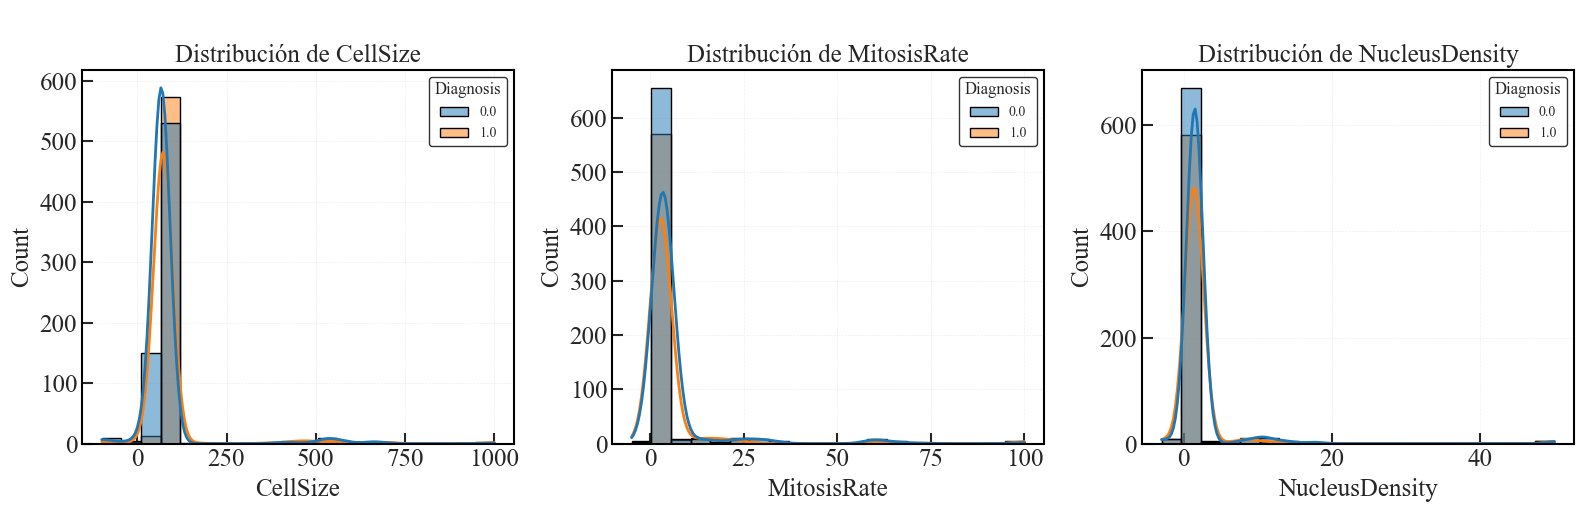

Gráfico guardado en: ../figures/p1/correlation_heatmap_numerical_features_outliers.png


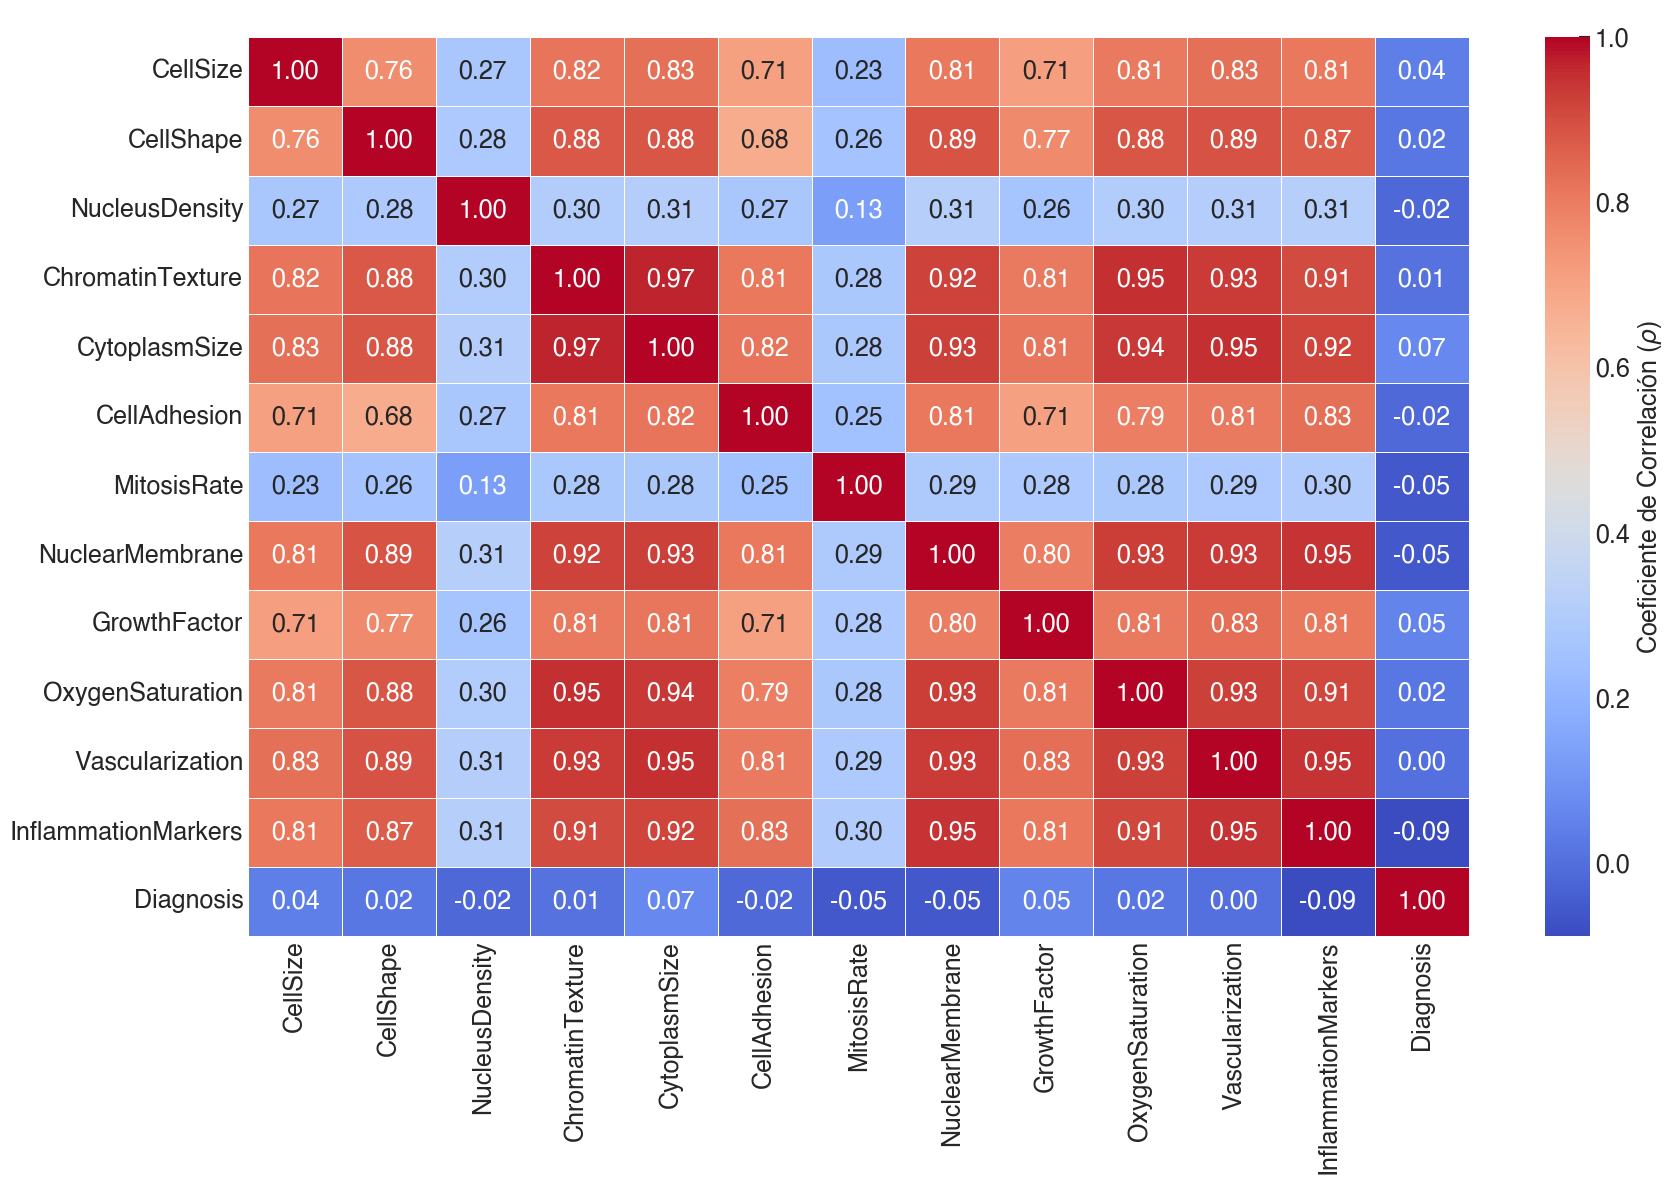

Gráfico guardado en: ../figures/p1/boxplots_outliers_analysis.png


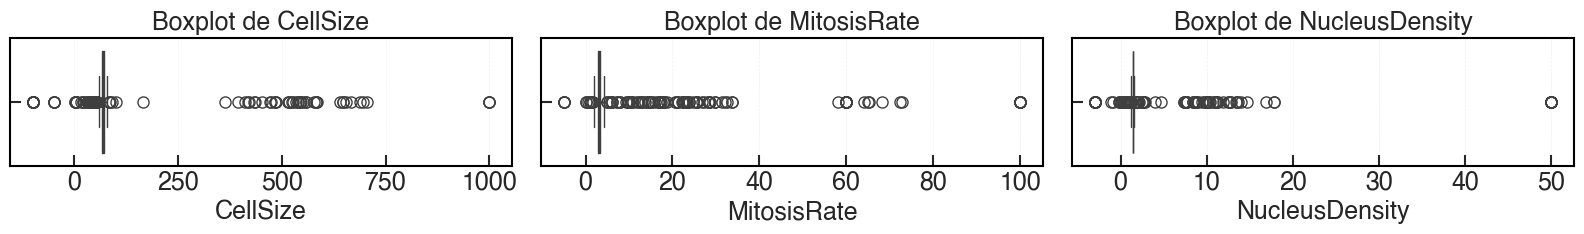

In [10]:


fig_params = {
    "heatmap_params": {
        "title": " ",
        "label_fontsize": 20,
        "title_fontsize": 20,
        "tick_fontsize": 20,
        "cbar_fontsize": 20,
        "annot_fontsize": 20,
        "figsize": (18, 12),
        "filename": "correlation_heatmap_numerical_features_outliers.png"
    },

    "dist_params": {
        "title": " ",
        "filename": "numerical_distributions_outliers.png",
        "features_to_plot":FEATURES_TO_PLOT,
        "tick_fontsize": 22,
        "label_fontsize": 22,
        "title_fontsize": 22,
        "figsize": (16, 5)
    },

    "outlier_params": {
        "filename": "outliers_bocxplots_balanced.png",
        "features_to_plot":FEATURES_TO_PLOT,
        "figsize": (20, 5)
    }
}

plot_data_analysis_all_visualizations(
    cell_diagnosis_balanced_for_train_outliers,
    numerical_cols_cell_diagnosis,
    "Diagnosis",
    FEATURES_TO_PLOT,
    "figures",
    fig_output_dir_p1
);

### Reemplazo de Outliers

In [11]:
cell_diagnosis_balanced_train, params = replace_outliers_iqr(
    cell_diagnosis_balanced_for_train_outliers, method="winsorize", return_params=True, target_column="Diagnosis"
)
cell_diagnosis_balanced_valid = replace_outliers_iqr(
    cell_diagnosis_balanced_for_valid_outliers, method="winsorize", params=params, target_column="Diagnosis"
)
cell_diagnosis_balanced_test = replace_outliers_iqr(
    cell_diagnosis_balanced_test_outliers, method="winsorize", params=params, target_column="Diagnosis"
)


In [12]:

loader_cell_diagnosis.update(
    df_train=cell_diagnosis_balanced_train,
    df_valid=cell_diagnosis_balanced_valid,
    df_test=cell_diagnosis_balanced_test
)

In [13]:

data_dict = {
    'df_train': cell_diagnosis_balanced_train,
    'df_valid': cell_diagnosis_balanced_valid,
    'df_test': cell_diagnosis_balanced_test
}

save_processed_data(
    loader=loader_cell_diagnosis,
    data_dict=data_dict,
    data_dir=data_dir_p1,
    dataset_name="cell_diagnosis_balanced",
    processing_type="processed"
)

In [14]:

loader_cell_diagnosis.read_data(
    train_file="processed/cell_diagnosis_balanced_train.csv",
    valid_file="processed/cell_diagnosis_balanced_valid.csv",
    test_file="processed/cell_diagnosis_balanced_test.csv",
    splitted=True
)
cell_diagnosis_balanced_train, cell_diagnosis_balanced_valid, cell_diagnosis_balanced_test = loader_cell_diagnosis.get_pandas_data(splitted=True)


Gráfico guardado en: figures/numerical_distributions_outliers.png


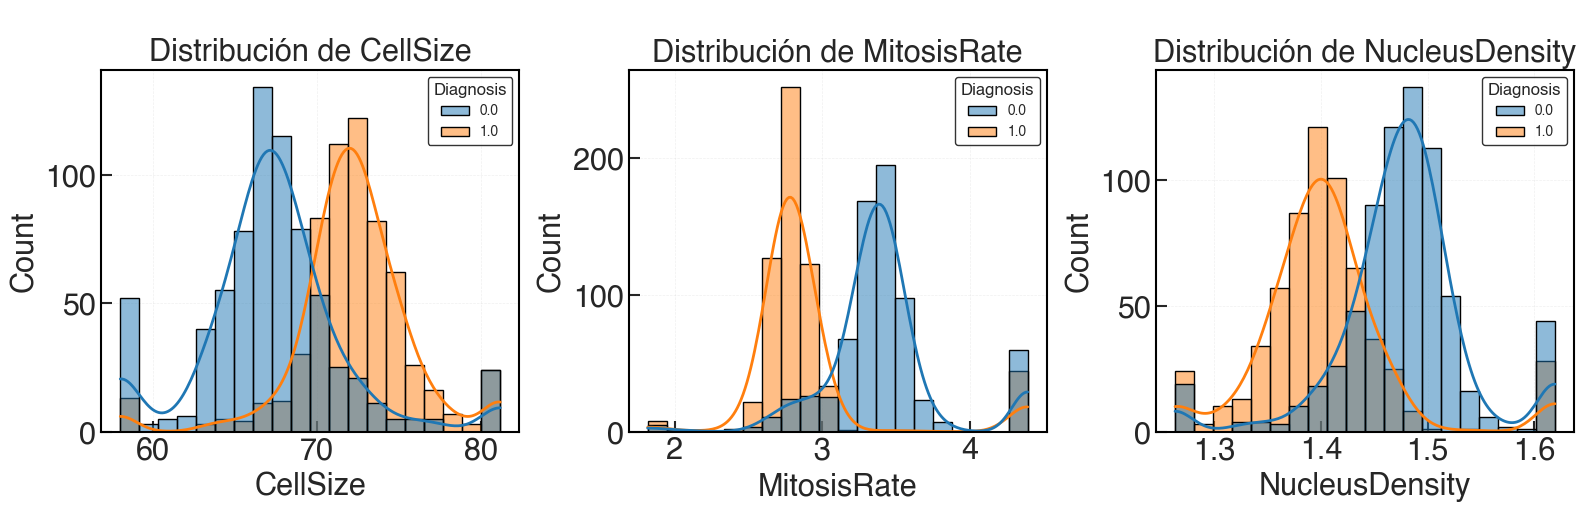

Gráfico guardado en: ../figures/p1/numerical_distributions_outliers_balanced.png


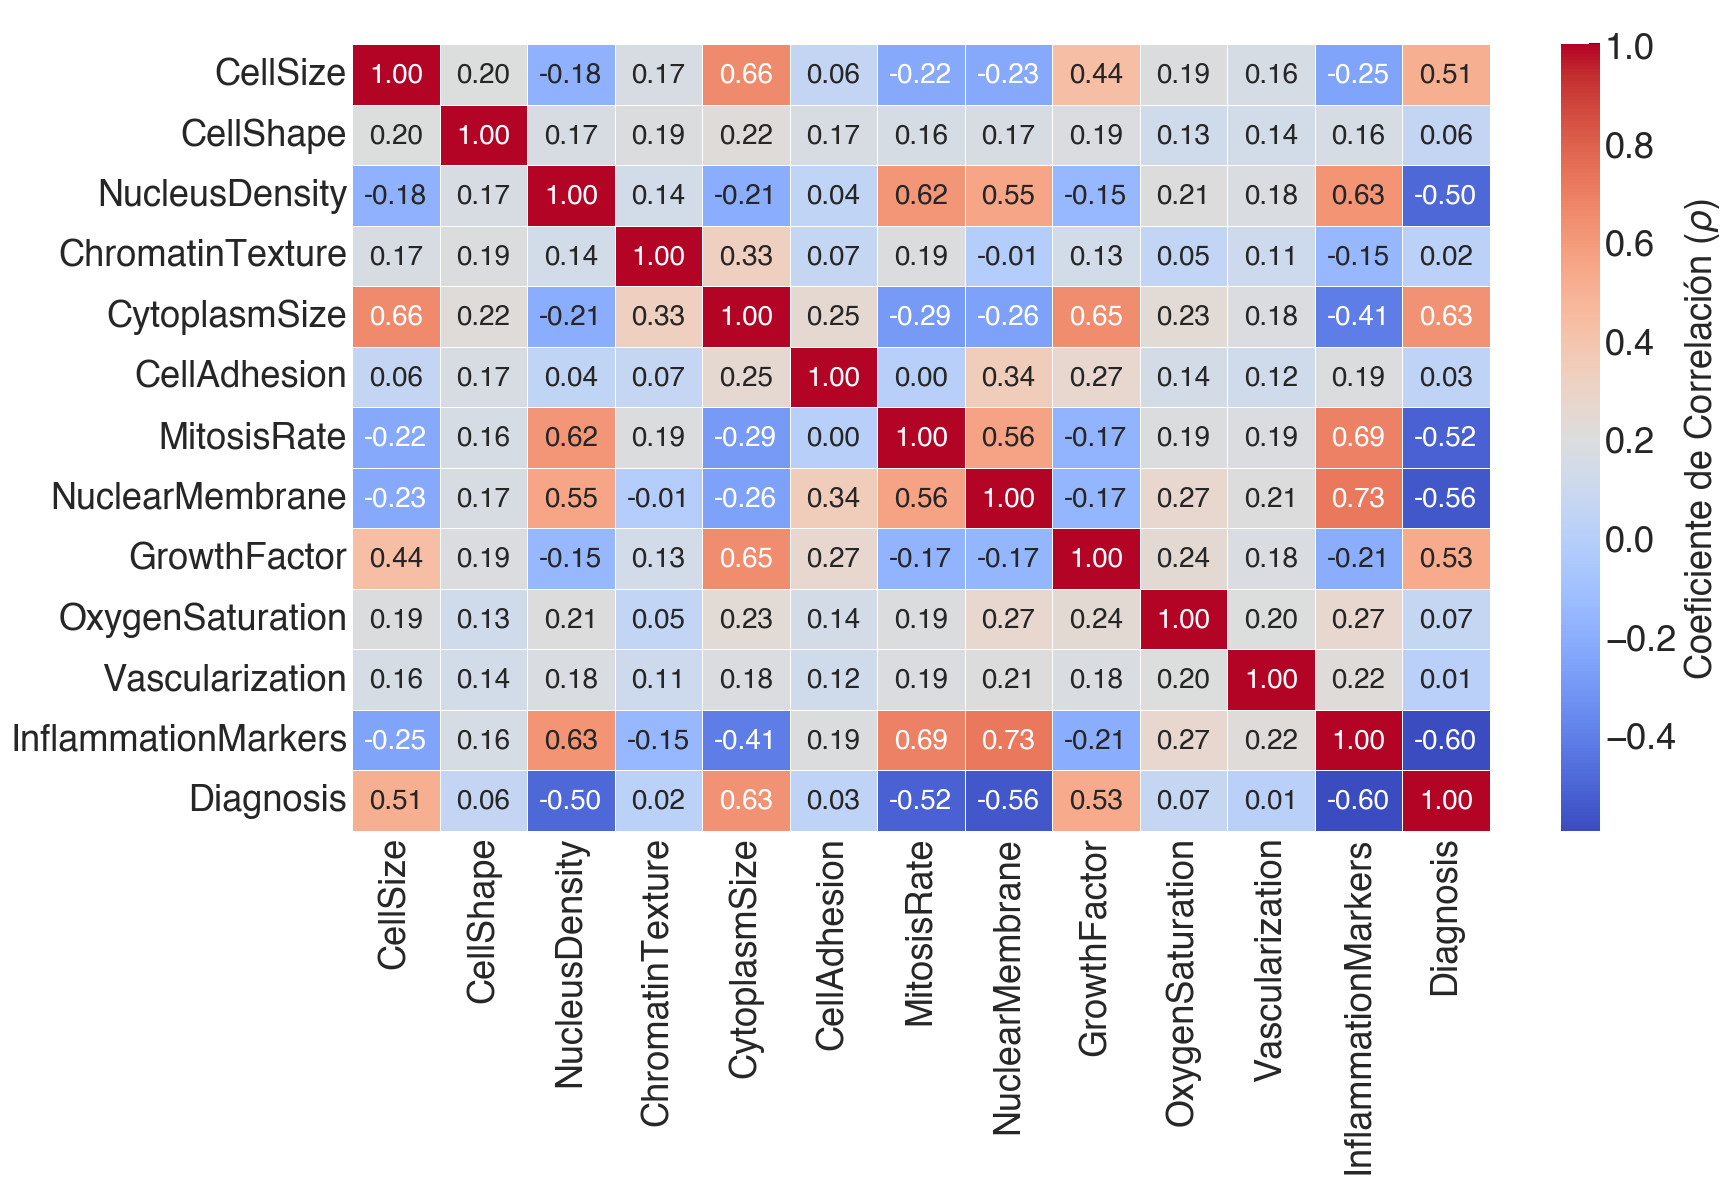

Gráfico guardado en: ../figures/p1/outliers_corrected_balanced.png


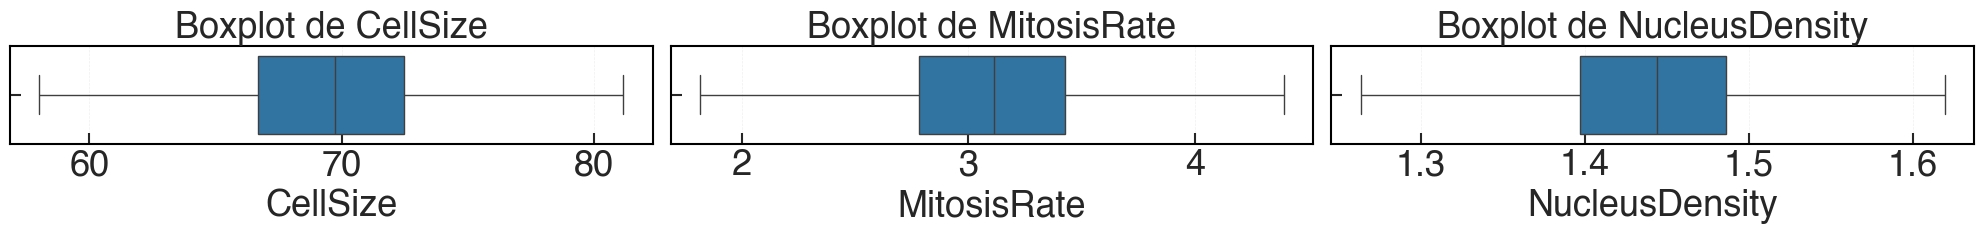

In [15]:

fig_params['heatmap_params']['tick_fontsize'] = 26
fig_params['heatmap_params']['label_fontsize'] = 26
fig_params['heatmap_params']['title_fontsize'] = 26
fig_params['heatmap_params']['cbar_fontsize'] = 26
fig_params['heatmap_params']['annot_fontsize'] = 20
fig_params['heatmap_params']['filename'] = "numerical_distributions_outliers_balanced.png"
fig_params['outlier_params']['filename'] = "outliers_corrected_balanced.png"

plot_data_analysis_all_visualizations(
    cell_diagnosis_balanced_train,
    numerical_cols_cell_diagnosis,
    "Diagnosis",
    FEATURES_TO_PLOT,
    "figures",
    fig_output_dir_p1,
    fig_params
);

# Punto 1.2: Modelado con Regresión Logística - Feature Engineering

In [16]:
transformations = {
    "Nucleus_Cytoplasm_Ratio": lambda d: (d["CellSize"] - d["CytoplasmSize"]) / d["CytoplasmSize"],
    "ProliferationIndex": lambda d: d["GrowthFactor"] * d["MitosisRate"],
    "DensityTextureIndex": lambda d: d["NucleusDensity"] * d["ChromatinTexture"],
}
cell_diagnosis_balanced_train = apply_feature_engineering(cell_diagnosis_balanced_train, transformations, verbose=False)
cell_diagnosis_balanced_valid = apply_feature_engineering(cell_diagnosis_balanced_valid, transformations, verbose=False)
cell_diagnosis_balanced_test = apply_feature_engineering(cell_diagnosis_balanced_test, transformations, verbose=False)

%% Cross Validation para Optimización de Lambda

In [17]:

X_train_cell_diagnosis, y_train_cell_diagnosis, X_valid_cell_diagnosis, y_valid_cell_diagnosis = process_training_data(
    cell_diagnosis_balanced_train,
    cell_diagnosis_balanced_valid 
)


In [18]:
lambda_values = np.logspace(-6, 1, 20)

In [19]:

best_lambda, mean_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_balanced_for_cross_validation,
    y=y_train_cell_diagnosis_balanced_for_cross_validation,
    lambda_values=lambda_values,
    categorical_columns=["CellType", "GeneticMutation"],
    preprocess_per_fold=True,
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.5
)


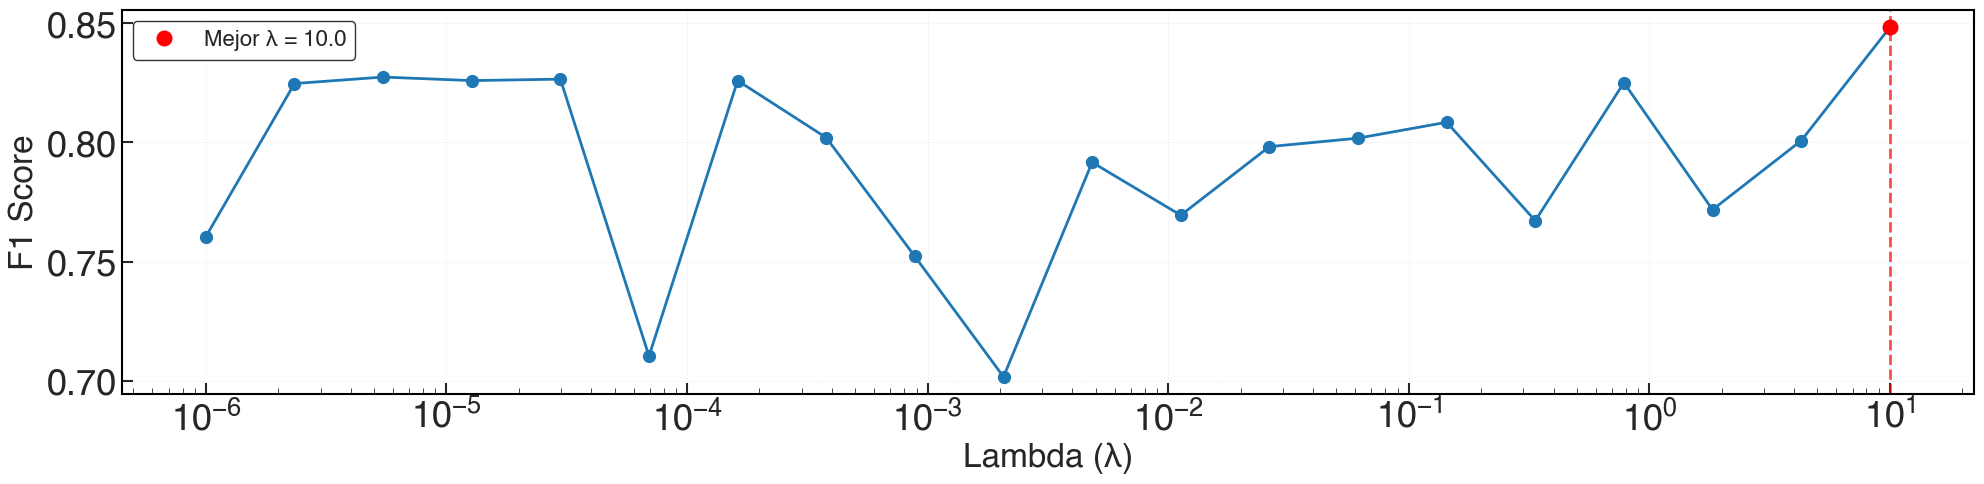

Optimal lambda value: 10.0


In [20]:
f1_score.__name__ = "F1 Score"
plot_lambda_tuning(
    lambda_values=lambda_values,
    scores=mean_scores,
    metric_name=f1_score.__name__,
    best_lambda=best_lambda,
    figsize=(20, 5)
)
plt.show()
print(f"Optimal lambda value: {best_lambda}")

### Entrenamiento Final y Evaluación en Conjunto de Validación

In [21]:

X_train_cell_diagnosis, y_train_cell_diagnosis, X_valid_cell_diagnosis, y_valid_cell_diagnosis = process_training_data(
    cell_diagnosis_balanced_train,
    cell_diagnosis_balanced_valid
)
final_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda
)

final_model = LogisticRegression(final_config)
final_model.fit(X_train_cell_diagnosis, y_train_cell_diagnosis);

Accuracy: 0.9066
Precision: 0.8815
Recall: 0.8881
F1 Score: 0.8848


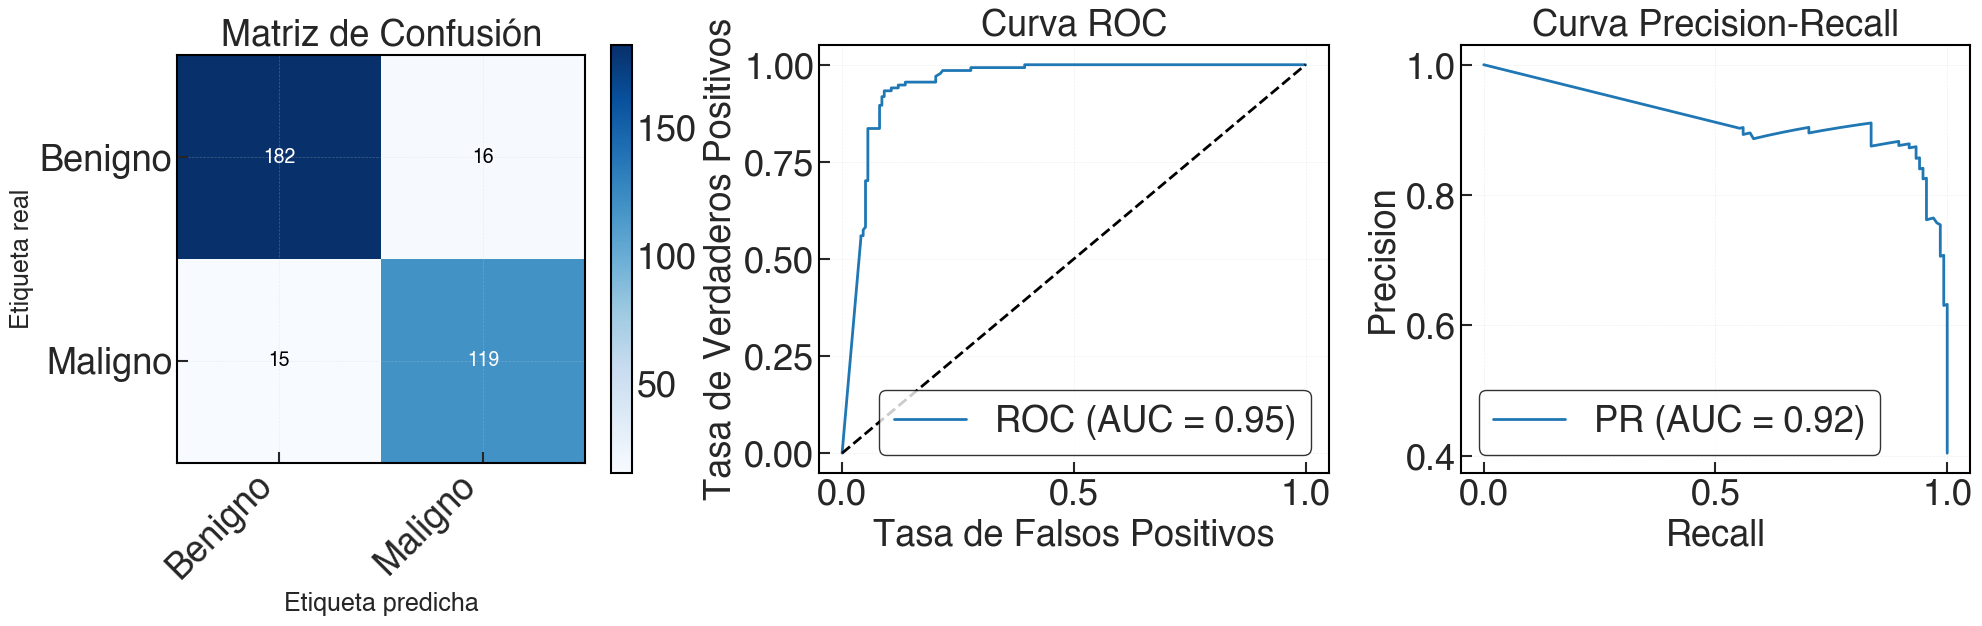

In [22]:
class_names_cell_diagnosis = ["Benigno", "Maligno"]
results = evaluate_model(
    threshold=0.5,
    model=final_model,
    X_test=X_valid_cell_diagnosis,
    y_test=y_valid_cell_diagnosis,
    class_names=class_names_cell_diagnosis,
    save_dir=fig_output_dir_p1,
    figsize=(20, 6),
    base_filename="valid_balanced_logistic_regression"
)

# Punto 1.3: Evaluación en Conjunto de Test Final

In [23]:

X_final_test_cell_diagnosis = cell_diagnosis_balanced_test.drop(columns=["Diagnosis"])
y_final_test_cell_diagnosis = cell_diagnosis_balanced_test["Diagnosis"]

X_final_test = DataLoader.encode_categorical(X_final_test_cell_diagnosis)
X_final_test_cell_diagnosis, y_final_test_cell_diagnosis = X_final_test.to_numpy(), y_final_test_cell_diagnosis.to_numpy()

Accuracy: 0.9189
Precision: 0.9250
Recall: 0.8916
F1 Score: 0.9080


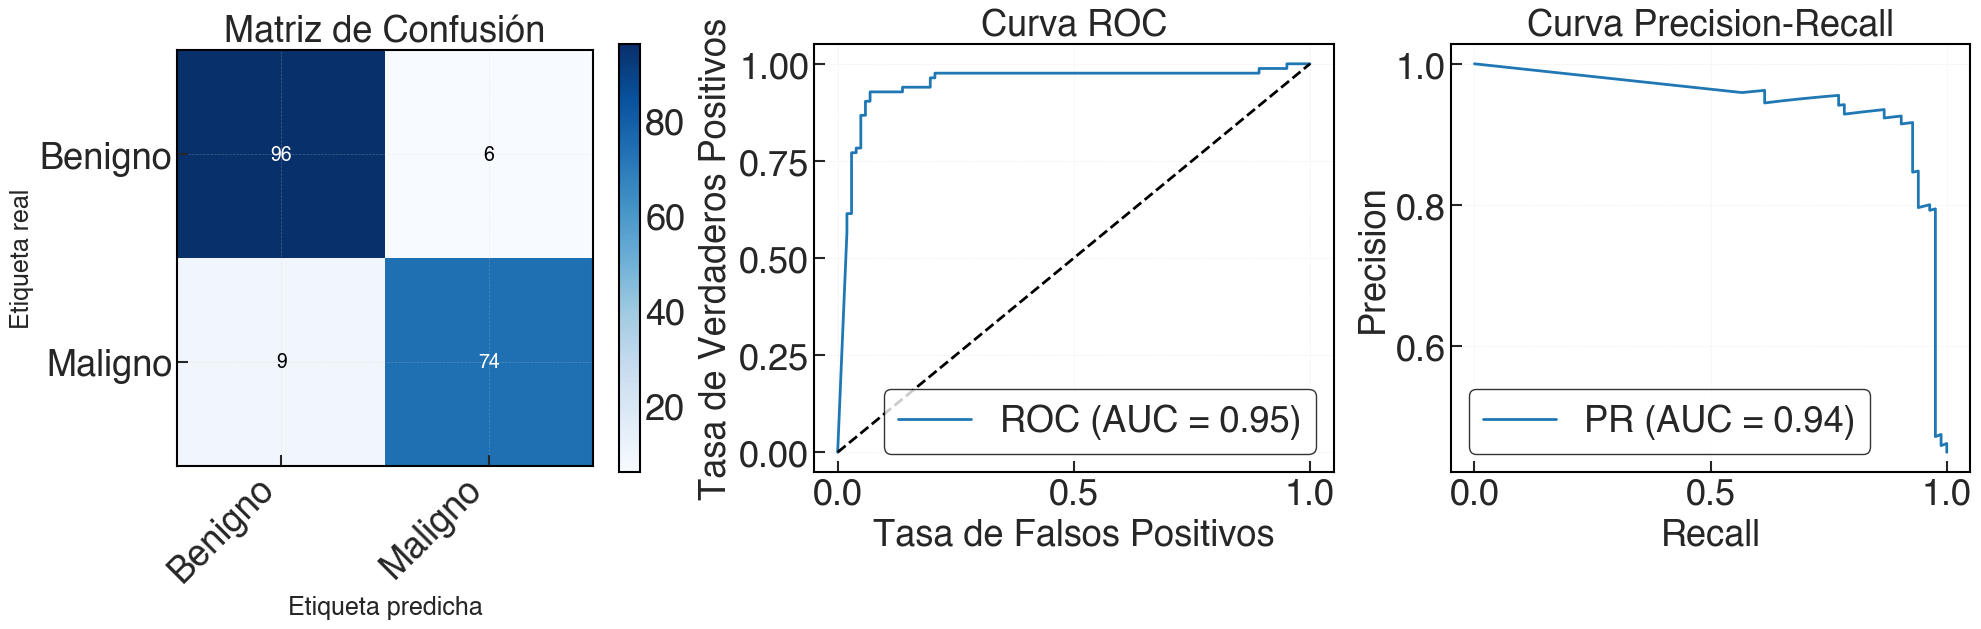

In [24]:

results = evaluate_model(
    model=final_model,
    X_test=X_final_test_cell_diagnosis,
    y_test=y_final_test_cell_diagnosis,
    class_names=class_names_cell_diagnosis,
    save_dir=fig_output_dir_p1,
    figsize=(20, 6),
    base_filename="test_balanced_logistic_regression"
)

# Punto 1.4: Datos Desbalanceados - Carga y Preprocesamiento

In [25]:
config_cell_diagnosis_imbalanced = DatasetConfig(
    data_dir=data_dir_p1,
    target_column="Diagnosis",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)
loader_cell_diagnosis_imbalanced = DataLoader(config_cell_diagnosis_imbalanced)
loader_cell_diagnosis_imbalanced.read_data(
    dev_file="raw/cell_diagnosis_imbalanced_dev.csv",
    test_file="raw/cell_diagnosis_imbalanced_test.csv",
    splitted=False
);

In [26]:

cell_diagnosis_imbalanced_dev_outliers, cell_diagnosis_imbalanced_test_outliers = loader_cell_diagnosis_imbalanced.get_pandas_data(splitted=False)

cell_diagnosis_imbalanced_for_train_outliers, cell_diagnosis_imbalanced_for_valid_outliers = train_valid_split(
    cell_diagnosis_imbalanced_dev_outliers, test_size=0.2, random_state=42, stratify=cell_diagnosis_imbalanced_dev_outliers["Diagnosis"]
)

In [27]:

analyze_categorical_variables(cell_diagnosis_imbalanced_for_train_outliers, ["CellType", "GeneticMutation", "Diagnosis"]);


Distribución de variables categóricas:

Distribución de CellType:


CellType  Conteo  Porcentaje (%)
0    Epthlial     304           36.67
1         ???     277           33.41
2  Mesnchymal     248           29.92


Distribución de GeneticMutation:


GeneticMutation  Conteo  Porcentaje (%)
0          Presnt     506           51.84
1           Absnt     470           48.16


Distribución de Diagnosis:


Diagnosis  Conteo  Porcentaje (%)
0        0.0     732            75.0
1        1.0     244            25.0

In [28]:
analyze_null_values(
    [cell_diagnosis_imbalanced_for_train_outliers, cell_diagnosis_imbalanced_test_outliers],
    ["conjunto de entrenamiento imbalanceado", "conjunto de prueba imbalanceado"]
);

Valores nulos en conjunto de entrenamiento imbalanceado:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                187           19.16
1             CellShape                191           19.57
2        NucleusDensity                178           18.24
3      ChromatinTexture                166           17.01
4         CytoplasmSize                189           19.36
5          CellAdhesion                171           17.52
6           MitosisRate                193           19.77
7       NuclearMembrane                181           18.55
8          GrowthFactor                181           18.55
9      OxygenSaturation                175           17.93
10      Vascularization                191           19.57
11  InflammationMarkers                180           18.44
12            Diagnosis                  0            0.00
13             CellType                147           15.06
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       905           92.73
1           Muestras sin valores nulos        71            7.27
2                    Total de muestras       976          100.00



Valores nulos en conjunto de prueba imbalanceado:


Columna  Cantidad de nulos  Porcentaje (%)
0              CellSize                 25           18.38
1             CellShape                 31           22.79
2        NucleusDensity                 28           20.59
3      ChromatinTexture                 25           18.38
4         CytoplasmSize                 23           16.91
5          CellAdhesion                 19           13.97
6           MitosisRate                 31           22.79
7       NuclearMembrane                 16           11.76
8          GrowthFactor                 32           23.53
9      OxygenSaturation                 25           18.38
10      Vascularization                 31           22.79
11  InflammationMarkers                 28           20.59
12            Diagnosis                  0            0.00
13             CellType                 21           15.44
14      GeneticMutation                  0            0.00

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo       127           93.38
1           Muestras sin valores nulos         9            6.62
2                    Total de muestras       136          100.00

In [29]:

X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation = cell_diagnosis_imbalanced_for_train_outliers.drop(columns=["Diagnosis"])

y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation = cell_diagnosis_imbalanced_for_train_outliers["Diagnosis"].to_numpy()


In [30]:

cell_diagnosis_imbalanced_for_train_outliers, cell_diagnosis_imbalanced_for_valid_outliers, cell_diagnosis_imbalanced_test_outliers = impute_missing_values(
    cell_diagnosis_imbalanced_for_train_outliers,
    cell_diagnosis_imbalanced_for_valid_outliers,
    cell_diagnosis_imbalanced_test_outliers,
    knn_neighbors=8,
    knn_weights="distance"
)

loader_cell_diagnosis_imbalanced.update(
    df_train=cell_diagnosis_imbalanced_for_train_outliers,
    df_valid=cell_diagnosis_imbalanced_for_valid_outliers,
    df_test=cell_diagnosis_imbalanced_test_outliers
);

Missing values before imputation:
Train: 2330 missing values
Valid: 582 missing values
Test: 335 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


In [31]:
# Guardar los datos preprocesados usando la función save_processed_data

data_dict = {
    'df_train': cell_diagnosis_imbalanced_for_train_outliers,
    'df_valid': cell_diagnosis_imbalanced_for_valid_outliers,
    'df_test': cell_diagnosis_imbalanced_test_outliers
}

save_processed_data(
    loader=loader_cell_diagnosis_imbalanced,
    data_dict=data_dict,
    data_dir=data_dir_p1,
    dataset_name="cell_diagnosis_imbalanced",
    processing_type="preprocessed"
)


In [32]:

loader_cell_diagnosis_imbalanced.read_data(
    train_file="preprocessed/cell_diagnosis_imbalanced_train.csv",
    valid_file="preprocessed/cell_diagnosis_imbalanced_valid.csv",
    test_file="preprocessed/cell_diagnosis_imbalanced_test.csv",
    splitted=True
);

Gráfico guardado en: figures/numerical_distributions_outliers.png


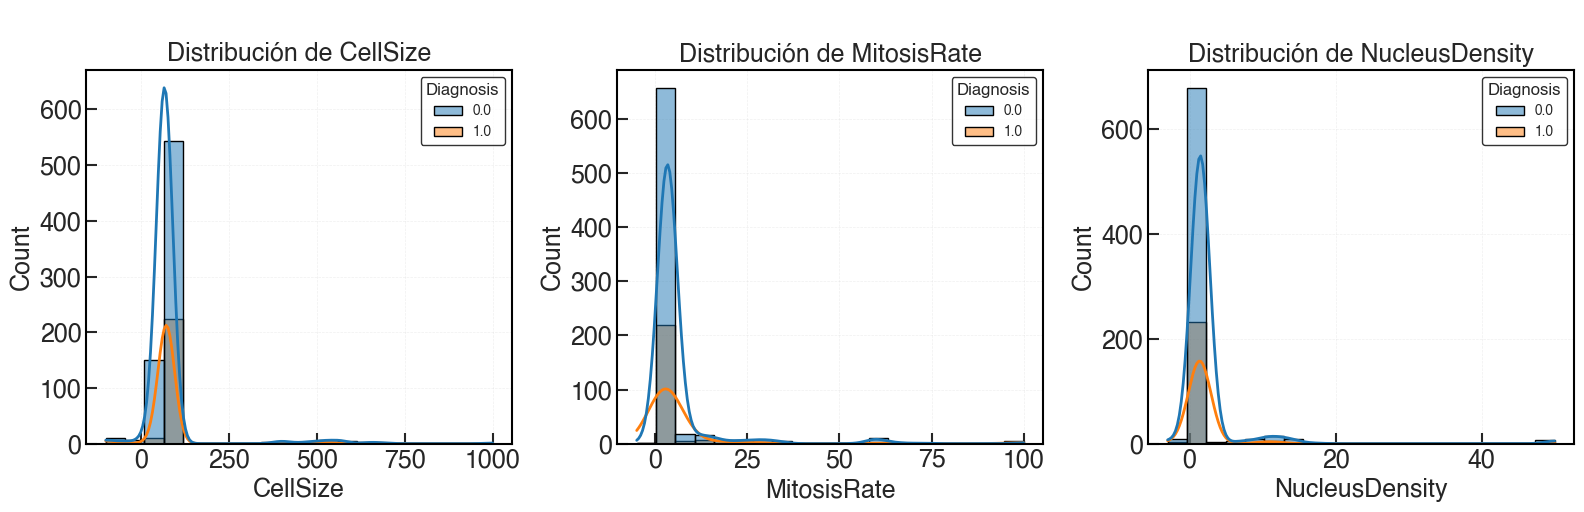

Gráfico guardado en: ../figures/p1/correlation_heatmap_numerical_features_outliers.png


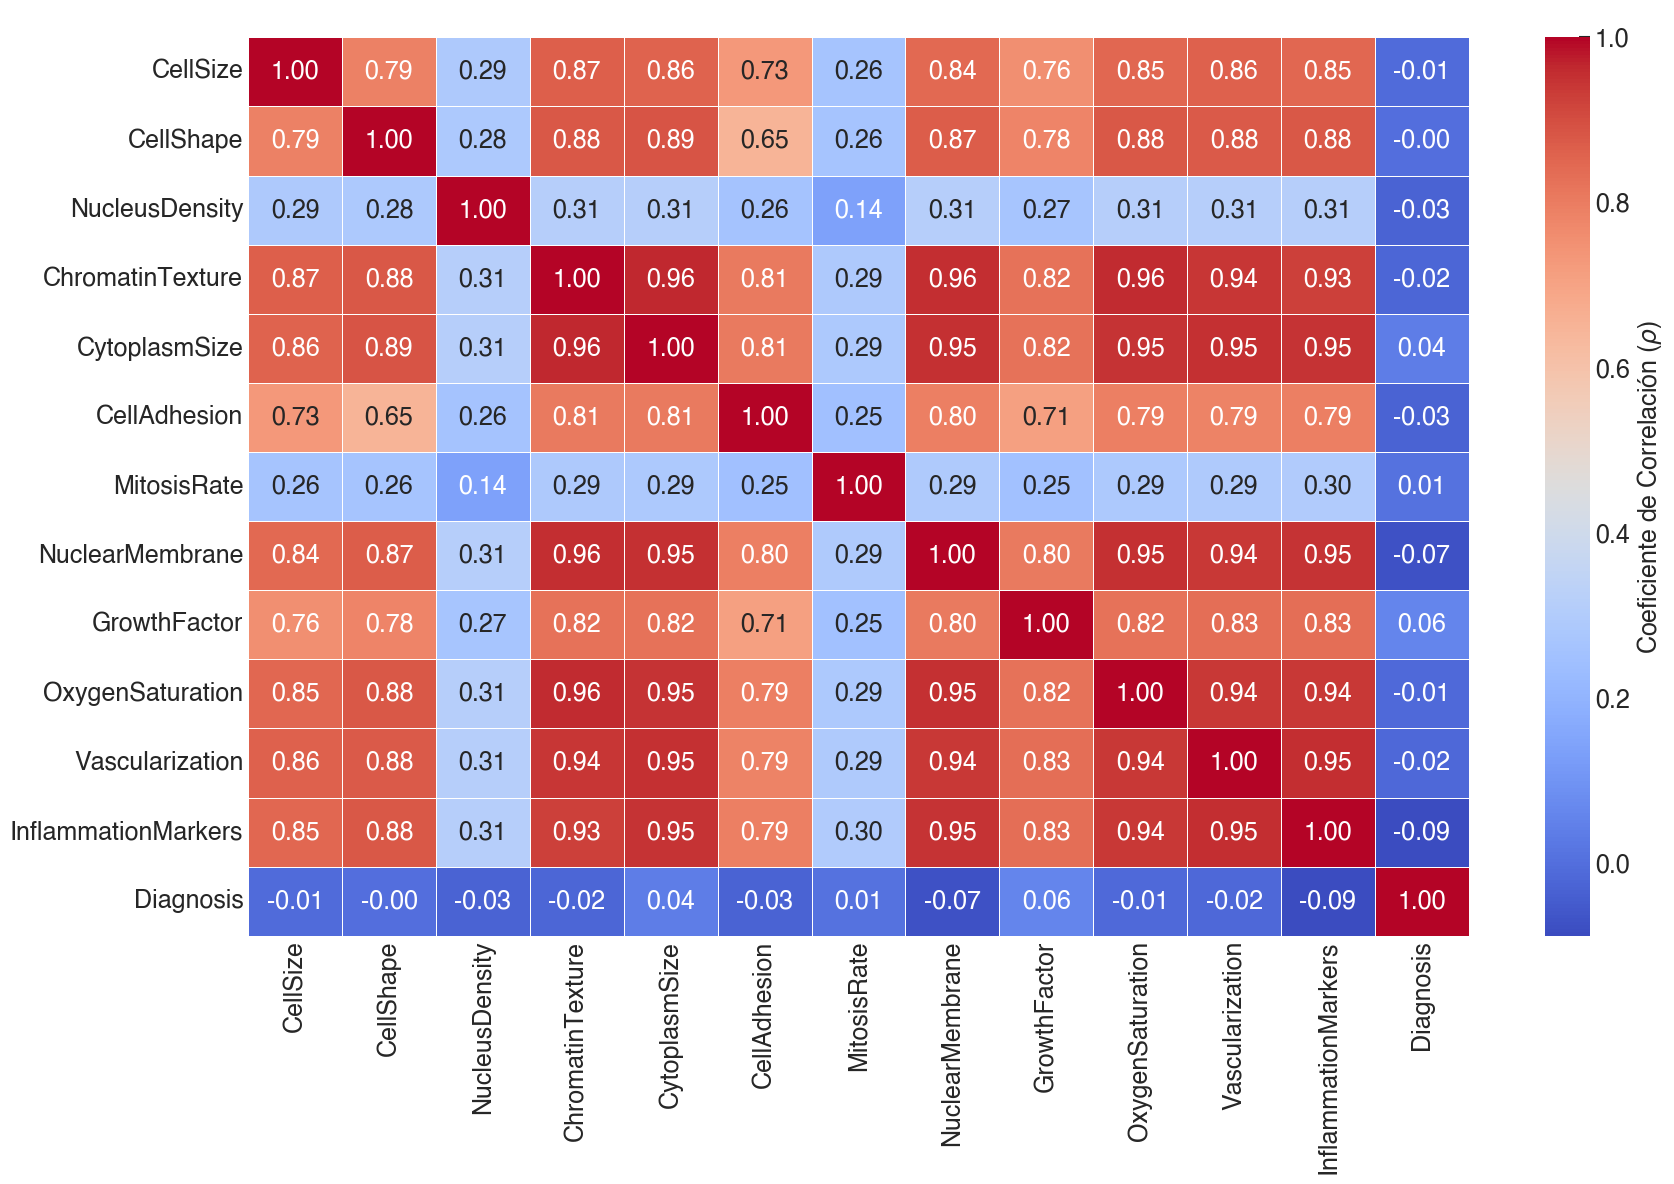

Gráfico guardado en: ../figures/p1/boxplots_outliers_analysis.png


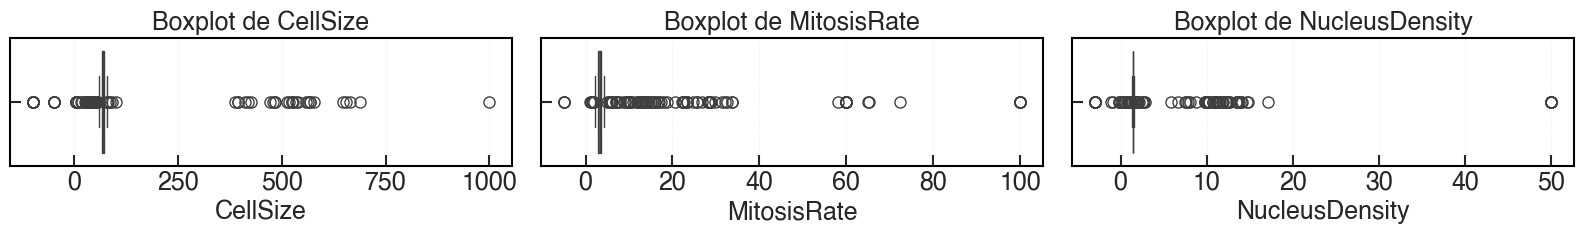

In [33]:


plot_data_analysis_all_visualizations(
    cell_diagnosis_imbalanced_for_train_outliers,
    numerical_cols_cell_diagnosis,
    "Diagnosis",
    FEATURES_TO_PLOT,
    "figures",
    fig_output_dir_p1
);


In [34]:

cell_diagnosis_imbalanced_for_train, params = replace_outliers_iqr(
    cell_diagnosis_imbalanced_for_train_outliers, method="winsorize", return_params=True, target_column="Diagnosis"
)
cell_diagnosis_imbalanced_for_valid = replace_outliers_iqr(
    cell_diagnosis_imbalanced_for_valid_outliers, method="winsorize", params=params, target_column="Diagnosis"
)
cell_diagnosis_imbalanced_test = replace_outliers_iqr(
    cell_diagnosis_imbalanced_test_outliers, method="winsorize", params=params, target_column="Diagnosis"
)


In [35]:
data_dict = {
    'df_train': cell_diagnosis_imbalanced_for_train,
    'df_valid': cell_diagnosis_imbalanced_for_valid,
    'df_test': cell_diagnosis_imbalanced_test
}

save_processed_data(
    loader=loader_cell_diagnosis_imbalanced,
    data_dict=data_dict,
    data_dir=data_dir_p1,
    dataset_name="cell_diagnosis_imbalanced",
    processing_type="processed"
)

In [36]:

loader_cell_diagnosis_imbalanced.read_data(
    train_file="processed/cell_diagnosis_imbalanced_train.csv",
    valid_file="processed/cell_diagnosis_imbalanced_valid.csv",
    test_file="processed/cell_diagnosis_imbalanced_test.csv",
    splitted=True
);

Gráfico guardado en: figures/numerical_distributions_outliers.png


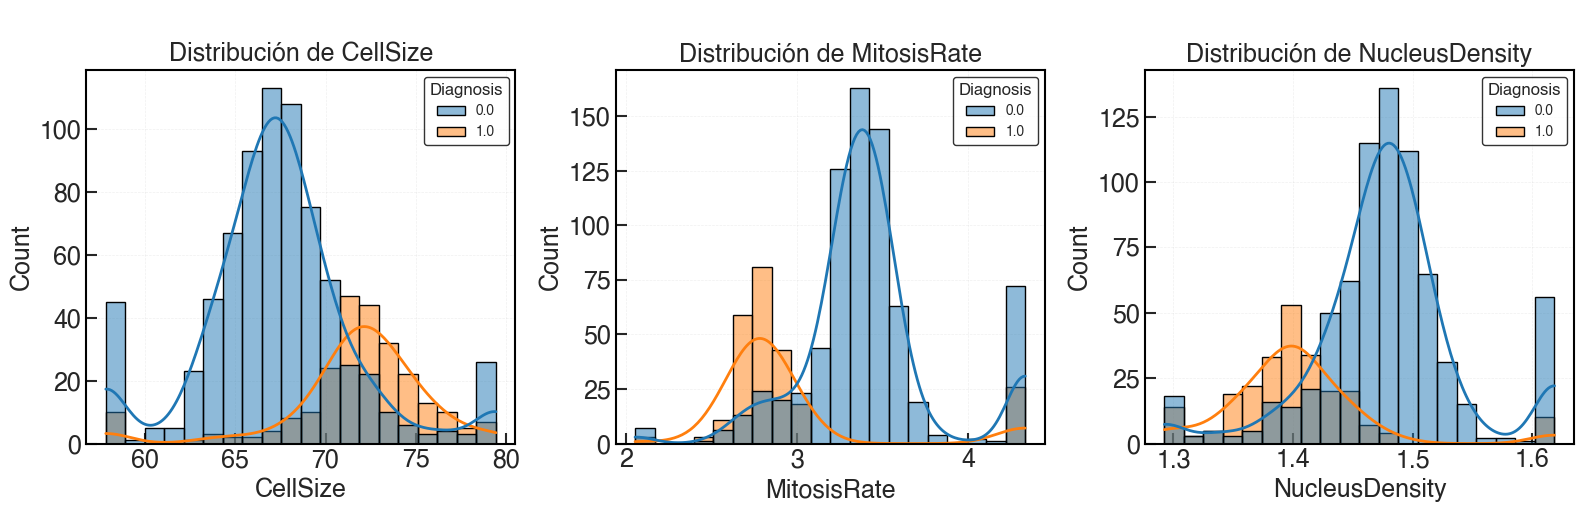

Gráfico guardado en: ../figures/p1/correlation_heatmap_numerical_features_outliers.png


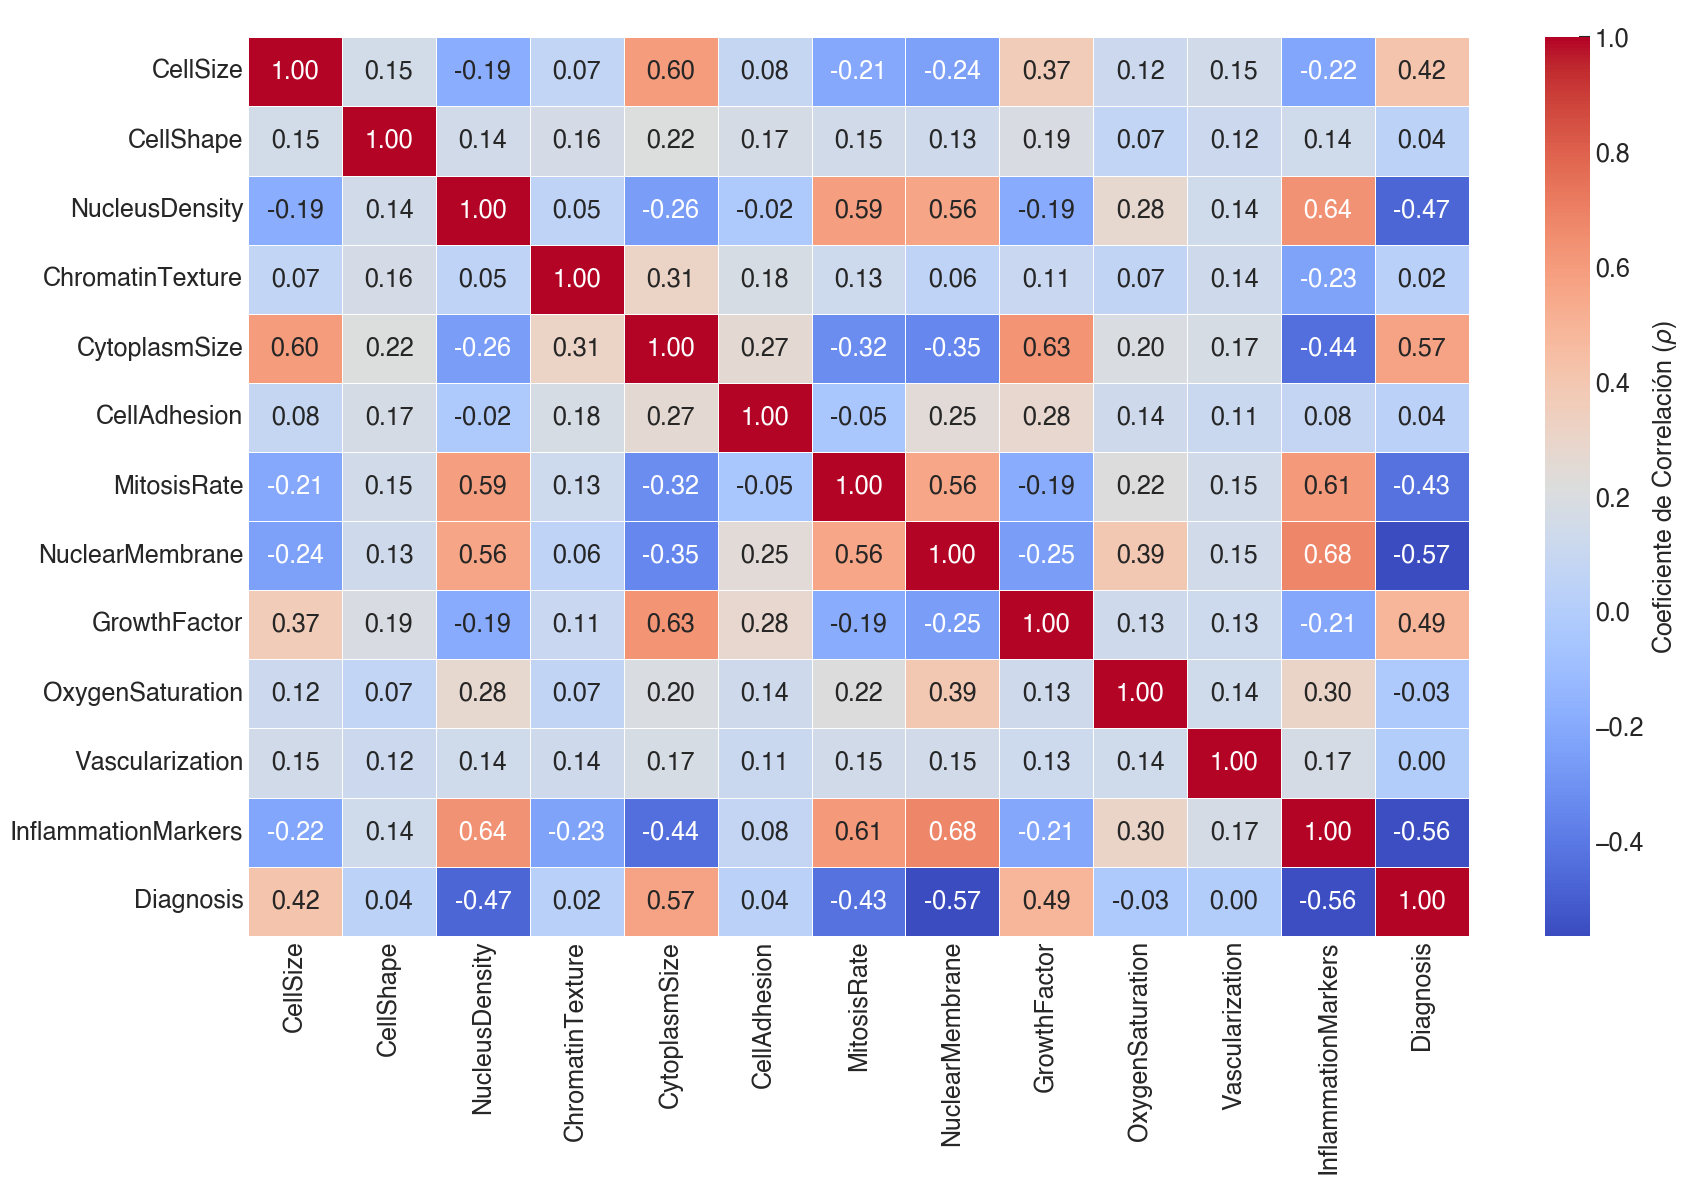

Gráfico guardado en: ../figures/p1/boxplots_outliers_analysis.png


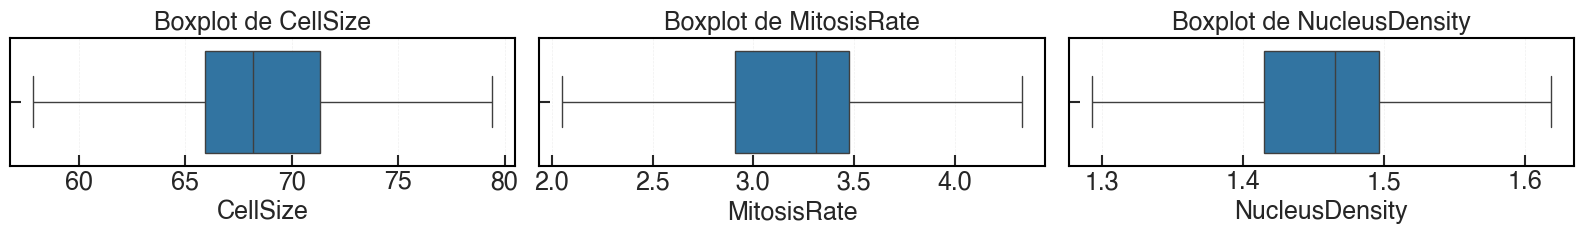

In [37]:

plot_data_analysis_all_visualizations(
    cell_diagnosis_imbalanced_for_train,
    numerical_cols_cell_diagnosis,
    "Diagnosis",
    FEATURES_TO_PLOT,
    "figures",
    fig_output_dir_p1
);


In [38]:

# Ejemplo de uso
X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced, X_val_cell_diagnosis_imbalanced, y_val_cell_diagnosis_imbalanced = process_training_data(
    cell_diagnosis_imbalanced_for_train,
    cell_diagnosis_imbalanced_for_valid
)


In [39]:
X_test_cell_diagnosis_imbalanced, y_test_cell_diagnosis_imbalanced = loader_cell_diagnosis_imbalanced.get_processed_test_data(
    return_numpy=True,
    encode_categorical=True,
    normalize=False
)


In [40]:
class_names = ["Malignant","Benign" ]

In [41]:
all_models = {}

### Entrenar con diferentes tecnicas de rebalancing

No rebalancing

In [42]:


best_lambda_nr, cv_scores_nr = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    stratified=True,
    lambda_values=lambda_values,     
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.5,
    categorical_columns=["CellType", "GeneticMutation"],
    preprocess_per_fold=True,
    aggregate_predictions=True,         
    resampler=None                      
)

print(f"Lambda óptimo para no rebalancing: {best_lambda_nr}")


Lambda óptimo para no rebalancing: 10.0


In [43]:

lr_config_no_rebalancing = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda_nr,
    random_state=42,
    verbose=False
)


model_no_rebalancing = LogisticRegression(lr_config_no_rebalancing)
model_no_rebalancing.fit(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)


metrics_no_rebalancing = evaluate_model(
    model=model_no_rebalancing,
    X_test=X_val_cell_diagnosis_imbalanced,
    y_test=y_val_cell_diagnosis_imbalanced, 
    class_names=class_names, 
    show_plots=False,
    threshold=0.5,
    figsize=(10, 6),
    print_metrics=True
)

all_models["No rebalancing"] = {
    "model": model_no_rebalancing,
    "metrics": metrics_no_rebalancing
}


Accuracy: 0.9050
Precision: 0.8136
Recall: 0.8000
F1 Score: 0.8067


Undersampling

In [44]:

undersampler = RandomUnderSampler(RebalancingConfig(random_state=42, sampling_strategy=0.5))


best_lambda_under, cv_scores_under = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    lambda_values=lambda_values,
    stratified=True,
    metric_fn=f1_score,       
    categorical_columns=["CellType", "GeneticMutation"],
    k_folds=5,
    verbose=False,
    threshold=0.5,
    aggregate_predictions=True,   
    resampler=undersampler        
)

print(f"Lambda óptimo para undersampling: {best_lambda_under}")


Lambda óptimo para undersampling: 1.274274985703132e-05


In [45]:

lr_config_under = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=best_lambda_under,
    random_state=42,
    verbose=False
)

X_train_under, y_train_under = undersampler.fit_resample(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)


model_undersampling = LogisticRegression(lr_config_under)
model_undersampling.fit(X_train_under, y_train_under)

metrics_undersampling = evaluate_model(
    threshold=0.5,
    model=model_undersampling, 
    X_test=X_val_cell_diagnosis_imbalanced, 
    y_test=y_val_cell_diagnosis_imbalanced, 
    class_names=class_names, 
    show_plots=False,
    figsize=(10, 6), 
    print_metrics=True
)

all_models["Undersampling"] = {
    "model": model_undersampling,
    "metrics": metrics_undersampling
}


Accuracy: 0.9132
Precision: 0.8000
Recall: 0.8667
F1 Score: 0.8320


Oversampling

Lambda óptimo para oversampling: 0.7847599703514607
Gráfico guardado en: ../figures/p1/lambda_tuning_oversampling


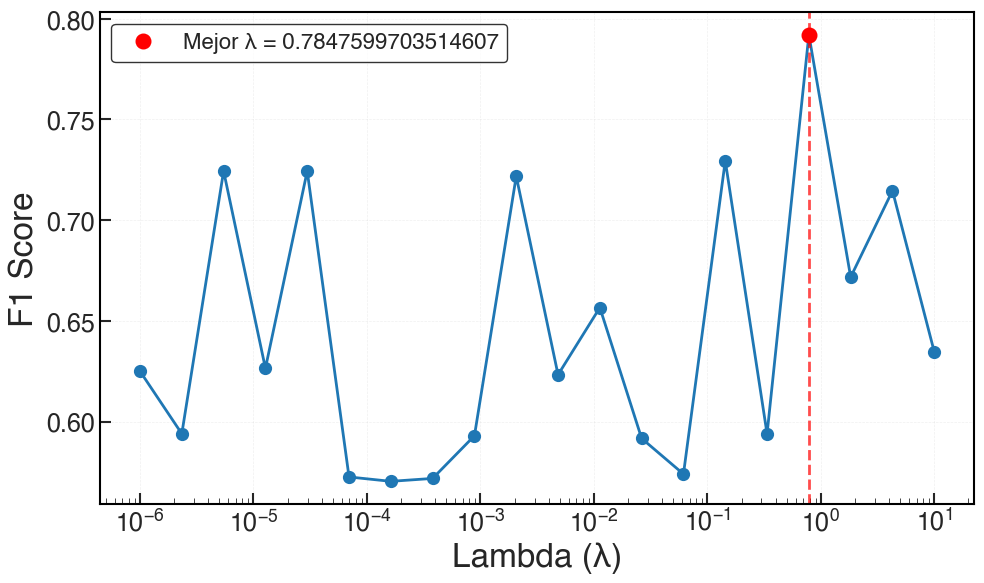

In [46]:
oversampler = RandomOverSampler(RebalancingConfig(random_state=12))


optimal_lambda, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,            
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    categorical_columns=["CellType", "GeneticMutation"],
    lambda_values=lambda_values,
    stratified=True,
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.5,
    resampler=oversampler  
)

print(f"Lambda óptimo para oversampling: {optimal_lambda}")

plot_lambda_tuning(lambda_values, cv_scores, metric_name="F1 Score", save_dir=fig_output_dir_p1, filename="lambda_tuning_oversampling", best_lambda=optimal_lambda)


In [47]:


lr_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=optimal_lambda,
    random_state=42,
    verbose=False
)


X_train_over, y_train_over = oversampler.fit_resample(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)


model_oversampling = LogisticRegression(lr_config)
model_oversampling.fit(X_train_over, y_train_over)


metrics_oversampling = evaluate_model(
    model=model_oversampling,
    X_test=X_val_cell_diagnosis_imbalanced,
    y_test=y_val_cell_diagnosis_imbalanced,
    class_names=class_names,
    show_plots=False,
    threshold=0.5,
    figsize=(10, 6),
    print_metrics=True
)

all_models["Oversampling duplicate"] = {
    "model": model_oversampling,
    "metrics": metrics_oversampling
}




Accuracy: 0.8967
Precision: 0.7465
Recall: 0.8833
F1 Score: 0.8092


SMOTE

Lambda óptimo para SMOTE: 4.281332398719387
Gráfico guardado en: ../figures/p1/lambda_tuning_cost_reweighting


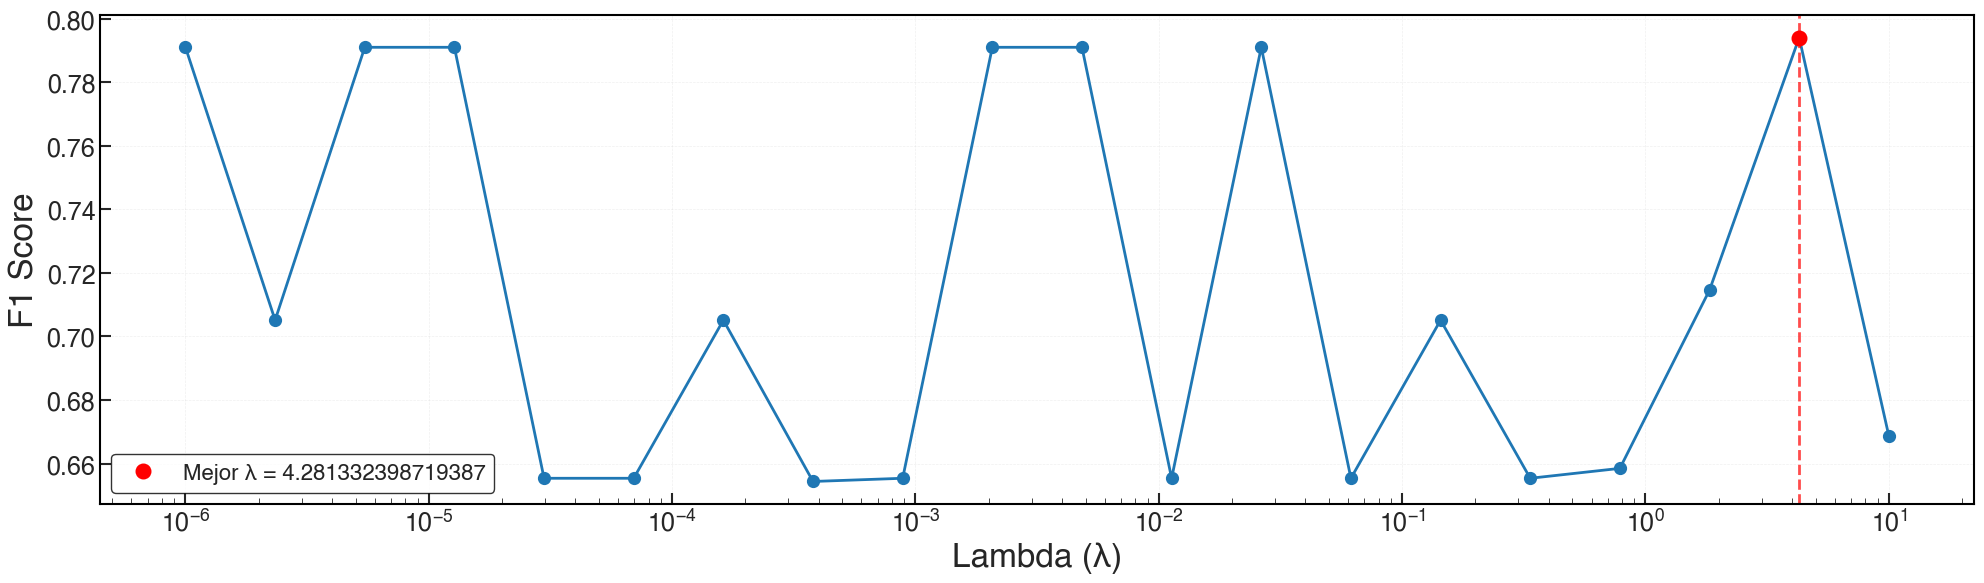

In [48]:

smote = SMOTE(SMOTEConfig(random_state=42, k_neighbors=5))

optimal_lambda, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,            
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    stratified=True,
    lambda_values=lambda_values,
    categorical_columns=["CellType", "GeneticMutation"],
    metric_fn=f1_score,
    k_folds=5,
    verbose=False,
    threshold=0.5,
    resampler=smote  
)

print(f"Lambda óptimo para SMOTE: {optimal_lambda}")

plot_lambda_tuning(lambda_values,
                   cv_scores,
                   metric_name="F1 Score",
                   save_dir=fig_output_dir_p1,
                   filename="lambda_tuning_cost_reweighting",
                   best_lambda=optimal_lambda,
                   figsize=(20, 6),
                   dpi=300
)



In [49]:

lr_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=1000,
    tol=1e-4,
    lambda_reg=optimal_lambda,
    random_state=42,
    verbose=False
)


X_train_smote, y_train_smote = smote.fit_resample(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

model_smote = LogisticRegression(lr_config)
model_smote.fit(X_train_smote, y_train_smote);

metrics_smote = evaluate_model(
    model_smote, X_val_cell_diagnosis_imbalanced, y_val_cell_diagnosis_imbalanced, 
    class_names=class_names, show_plots=False,
    threshold=0.5, figsize=(10, 6), print_metrics=True
)
all_models["Oversampling SMOTE"] = {
    "model": model_smote,
    "metrics": metrics_smote
}

Accuracy: 0.9174
Precision: 0.8030
Recall: 0.8833
F1 Score: 0.8413


Cost reweighting

Lambda óptimo para cost reweighting: 0.3359818286283781
Gráfico guardado en: ../figures/p1/lambda_tuning_cost_reweighting


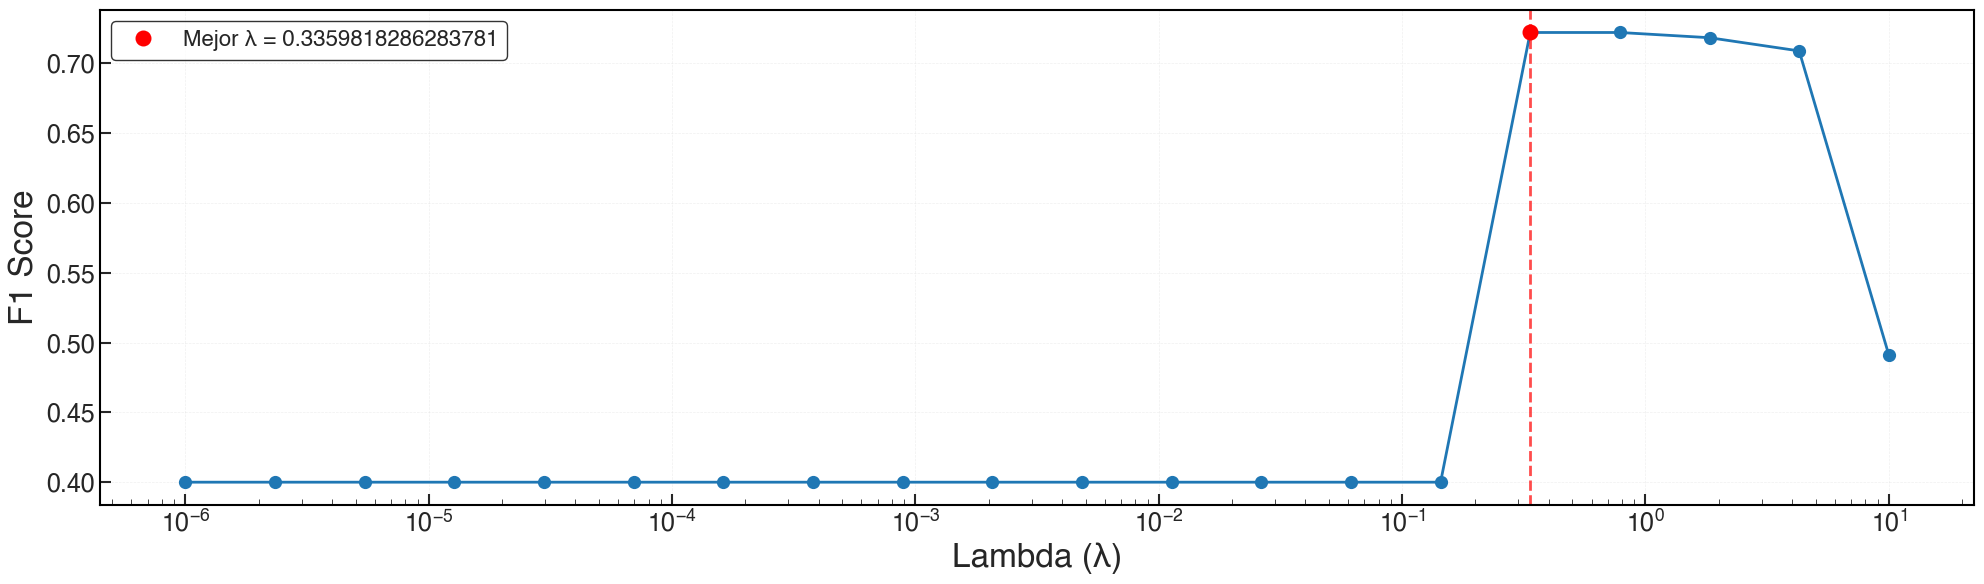

In [50]:

best_lambda_cost_rw, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    stratified=True,
    lambda_values=lambda_values,
    categorical_columns=["CellType", "GeneticMutation"],
    metric_fn=f1_score,          
    k_folds=5,
    verbose=False,
    threshold=0.5,
    apply_class_reweighting=True,
    aggregate_predictions=True,   
    resampler=None                
)

print(f"Lambda óptimo para cost reweighting: {best_lambda_cost_rw}")


plot_lambda_tuning(lambda_values,
                   cv_scores,
                   metric_name="F1 Score",
                   save_dir=fig_output_dir_p1,
                   filename="lambda_tuning_cost_reweighting",
                   best_lambda=best_lambda_cost_rw,
                   figsize=(20, 6),
                   dpi=300
)


In [87]:


class_weights = calculate_class_weights(y_train_cell_diagnosis_imbalanced)
print(f"Class weights: {class_weights}")


cost_sensitive_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=3000,
    tol=1e-4,
    lambda_reg=best_lambda_cost_rw,
    random_state=42,
    verbose=False,
    class_weight=class_weights
)
model_cost = LogisticRegression(cost_sensitive_config)
model_cost.fit(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced)

# Evaluar el modelo entrenado en el conjunto de validación
metrics_cost = evaluate_model(
    model=model_cost,
    X_test=X_val_cell_diagnosis_imbalanced,
    y_test=y_val_cell_diagnosis_imbalanced,
    class_names=class_names,
    show_plots=False,
    threshold=0.5,
    figsize=(10, 6),
    print_metrics=True
)

all_models["Cost re-weighting"] = {
    "model": model_cost,
    "metrics": metrics_cost
}



Class weights: {np.float64(0.0): 1.0, np.float64(1.0): np.float64(3.0)}
Accuracy: 0.9132
Precision: 0.7910
Recall: 0.8833
F1 Score: 0.8346


Evaluando modelos en el conjunto de validation
Evaluando No rebalancing
Evaluando Undersampling
Evaluando Oversampling duplicate
Evaluando Oversampling SMOTE
Evaluando Cost re-weighting
Gráfico guardado en: ../figures/p1/validation_combined_curves_comparison.png


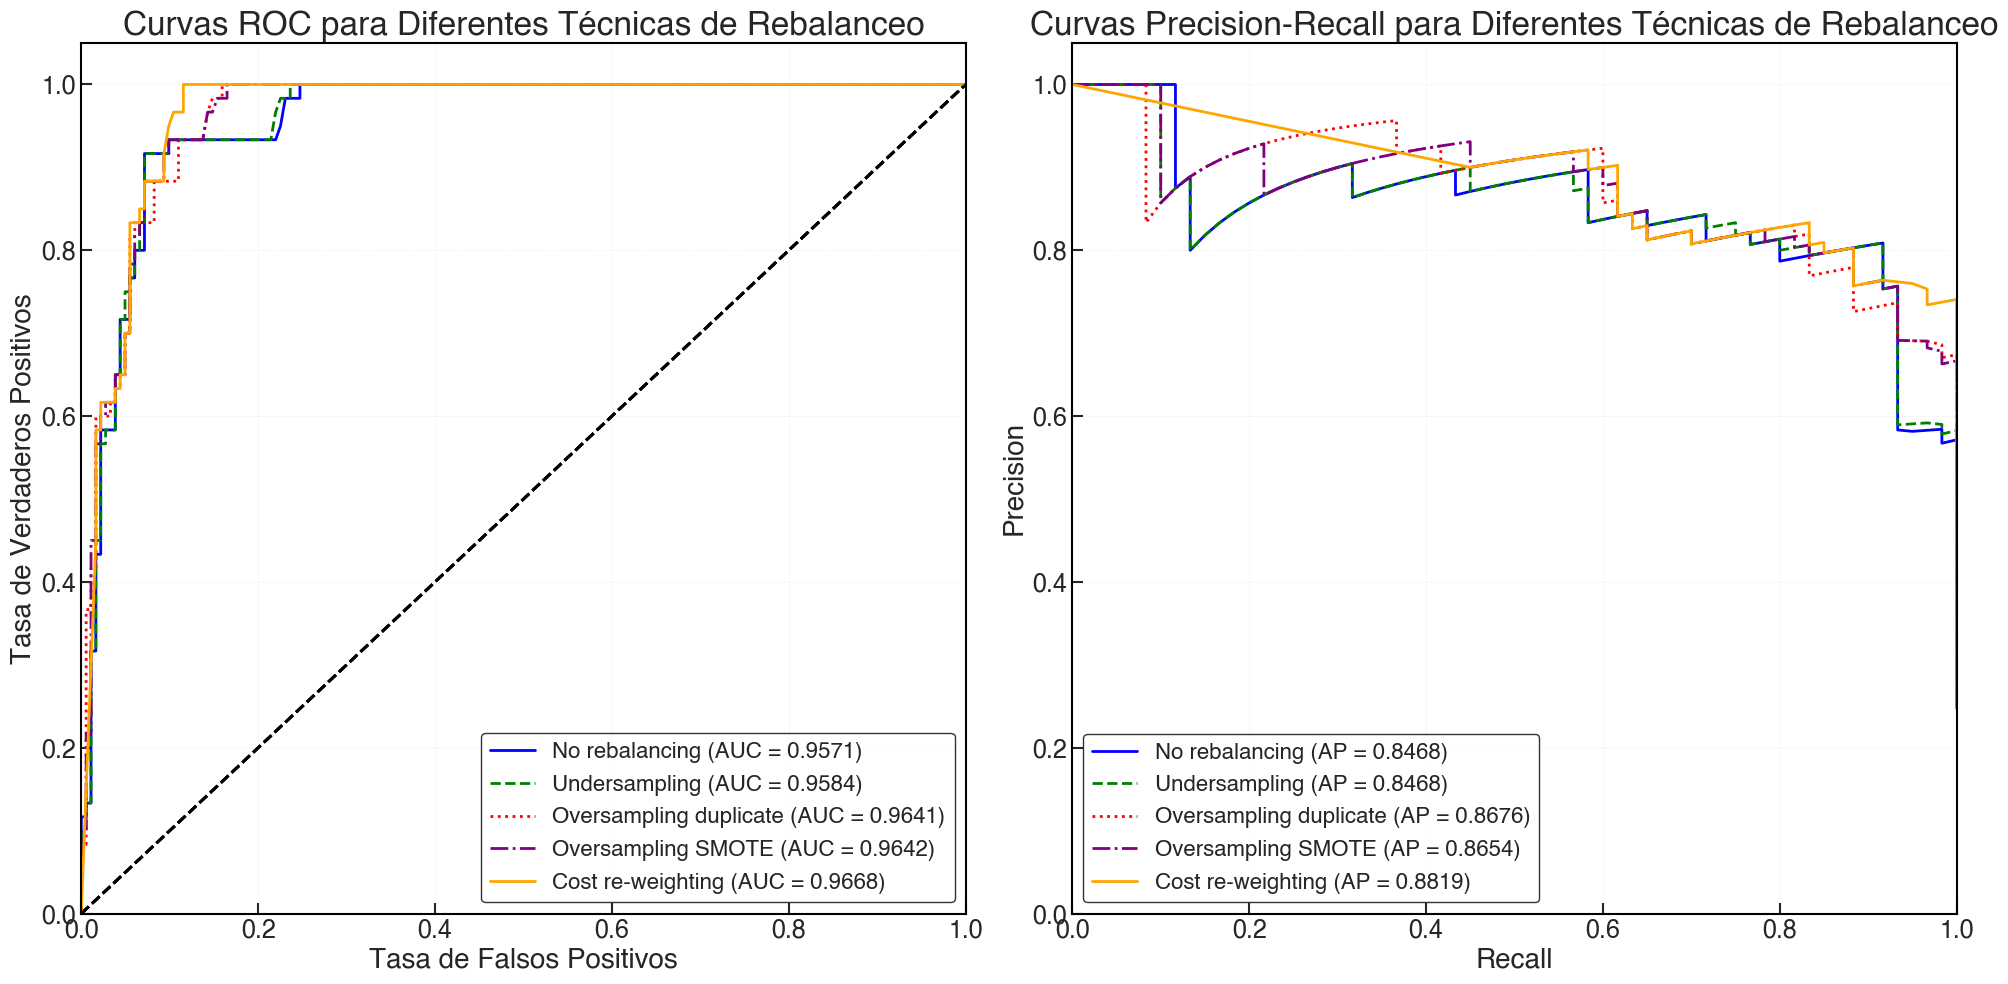

In [92]:
# asegurar que y_val_cell_diagnosis_imbalanced sea un array NumPy
y_val_cell_diagnosis_imbalanced = np.asarray(y_val_cell_diagnosis_imbalanced)

val_metrics_df, val_metrics = evaluate_all_models(
    all_models, 
    X_val_cell_diagnosis_imbalanced, 
    y_val_cell_diagnosis_imbalanced, 
   
    class_names, 
    fig_output_dir_p1,
    prefix="validation",
    subplots=True,
    show_plot=True,
    title_fontsize=24,
    label_fontsize=20,
    tick_fontsize=18,
    legend_fontsize=16,
    individual_plots=False
)

Evaluando modelos en el conjunto de test
Evaluando No rebalancing
Evaluando Undersampling
Evaluando Oversampling duplicate
Evaluando Oversampling SMOTE
Evaluando Cost re-weighting
Gráfico guardado en: ../figures/p1/test_combined_curves_comparison.png


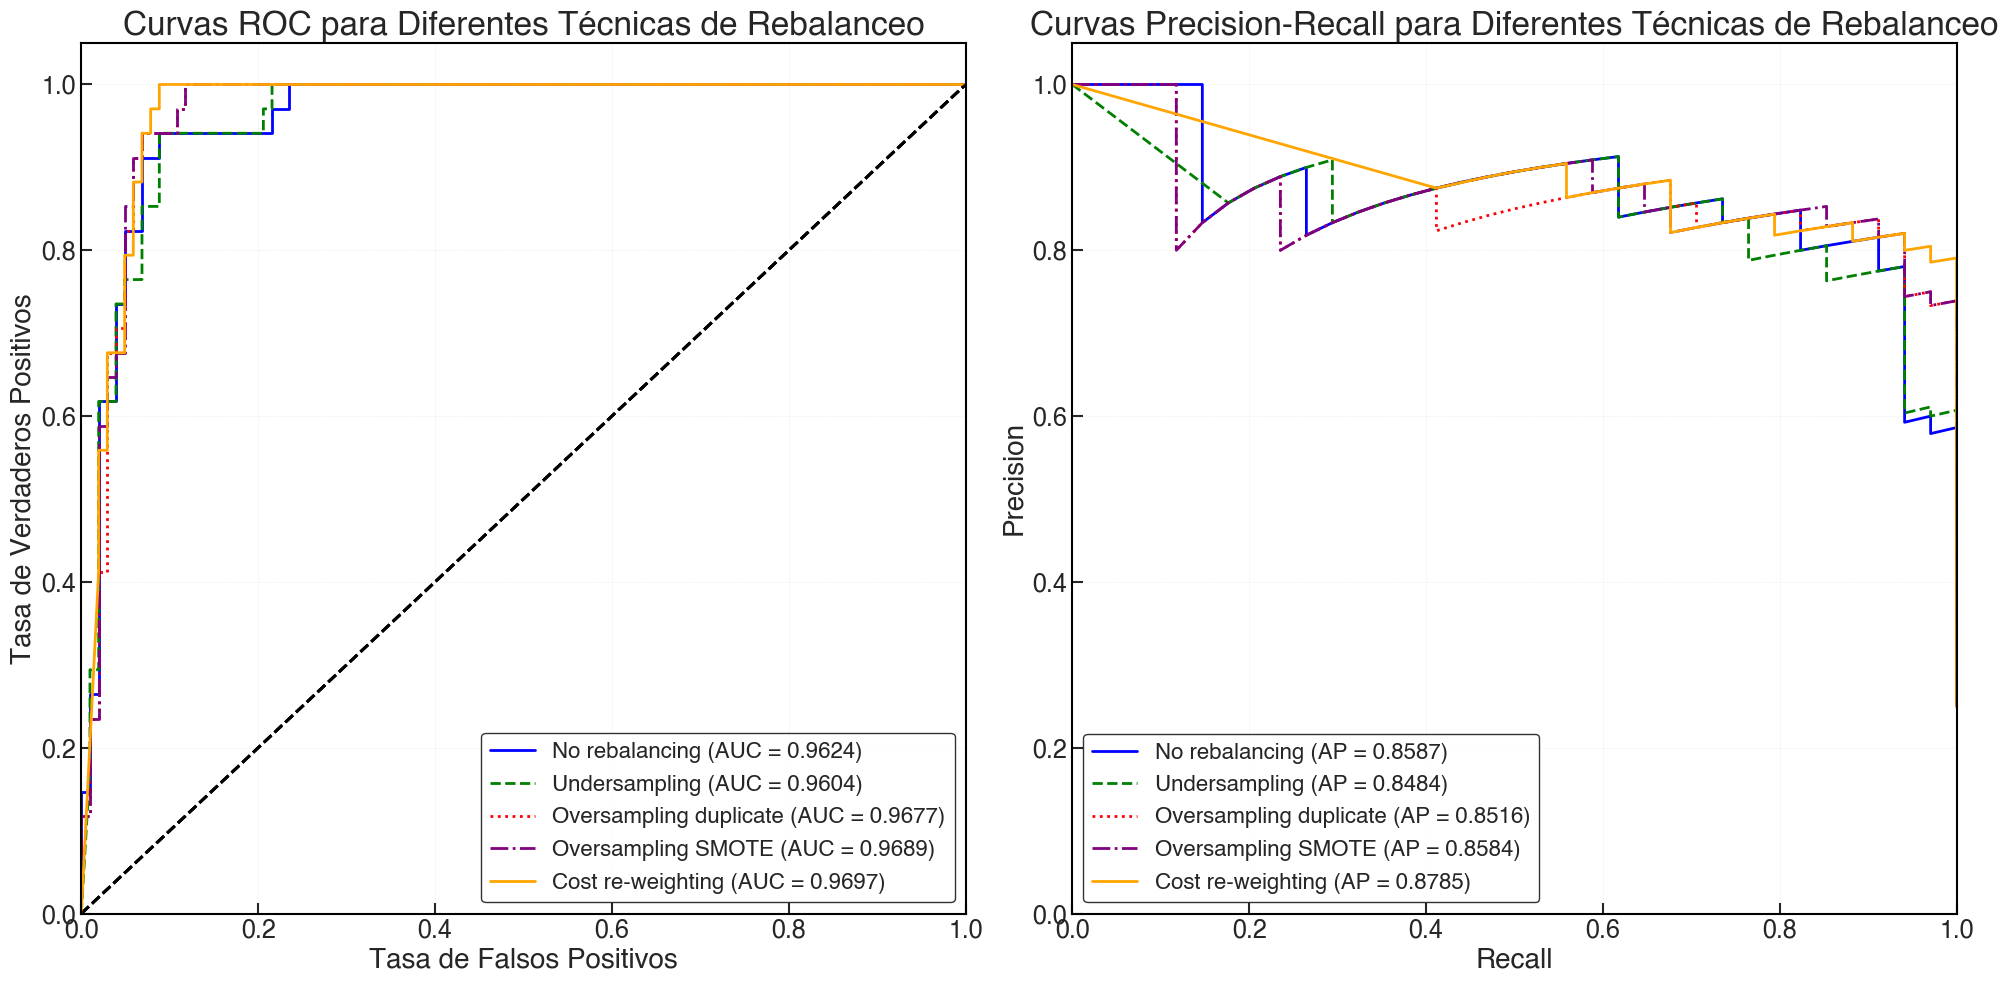

In [89]:
test_metrics_df, test_metrics = evaluate_all_models(
    all_models, 
    X_test_cell_diagnosis_imbalanced, 
    y_test_cell_diagnosis_imbalanced, 
    class_names, 
    fig_output_dir_p1,
    subplots=True,
    title_fontsize=24,
    label_fontsize=20,
    tick_fontsize=18,
    legend_fontsize=16,
    prefix="test",
    show_plot=True,
    individual_plots=False
)

In [90]:
from utils.utils import format_metrics_table
val_metrics_display = format_metrics_table(val_metrics_df, "Métricas de validación")
test_metrics_display = format_metrics_table(test_metrics_df, "Métricas de test")


===== Métricas de validación =====


Model Accuracy Precision  Recall F-Score AUC-ROC  AUC-PR
0          No rebalancing   0.9050    0.8136  0.8000  0.8067  0.9571  0.8468
1           Undersampling   0.9132    0.8000  0.8667  0.8320  0.9584  0.8468
2  Oversampling duplicate   0.8967    0.7465  0.8833  0.8092  0.9641  0.8676
3      Oversampling SMOTE   0.9174    0.8030  0.8833  0.8413  0.9642  0.8654
4       Cost re-weighting   0.9132    0.7910  0.8833  0.8346  0.9668  0.8819


===== Métricas de test =====


Model Accuracy Precision  Recall F-Score AUC-ROC  AUC-PR
0          No rebalancing   0.9044    0.8621  0.7353  0.7937  0.9624  0.8587
1           Undersampling   0.9044    0.8387  0.7647  0.8000  0.9604  0.8484
2  Oversampling duplicate   0.9338    0.8378  0.9118  0.8732  0.9677  0.8516
3      Oversampling SMOTE   0.9265    0.8529  0.8529  0.8529  0.9689  0.8584
4       Cost re-weighting   0.9265    0.8158  0.9118  0.8611  0.9697  0.8785

# Punto 1.6


El mejor modelo es cost reweighting porque tiene mejor auc pr y recall que oversampling que es el que tiene le mismo recall pero peor auc pr

In [55]:


best_lambda_cost_rw, cv_scores = cross_validate_lambda(
    X=X_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    y=y_train_cell_diagnosis_imbalanced_train_outliers_for_cross_validation,
    lambda_values=lambda_values,
    categorical_columns=["CellType", "GeneticMutation"],
    metric_fn=f1_score,          
    k_folds=5,
    verbose=False,
    apply_class_reweighting=True,
    threshold=0.5,
    aggregate_predictions=True       
)

print(f"\nOptimal lambda found: {best_lambda_cost_rw}")



Optimal lambda found: 4.281332398719387


In [56]:


cell_diagnosis_imbalanced_dev_outliers = impute_missing_values(
    cell_diagnosis_imbalanced_dev_outliers,
    knn_neighbors=5,
    knn_weights="distance"
)


cell_diagnosis_imbalanced_dev_outliers = replace_outliers_iqr(
    cell_diagnosis_imbalanced_dev_outliers,
    method="iqr",
    target_column="Diagnosis"
)



X_train_cell_diagnosis_imbalanced_dev_outliers = cell_diagnosis_imbalanced_dev_outliers.drop(columns=["Diagnosis"])


# Encoder la variable diagnosis
X_train_cell_diagnosis_imbalanced_dev_outliers = DataLoader.encode_categorical(X_train_cell_diagnosis_imbalanced_dev_outliers).to_numpy()
y_train_cell_diagnosis_imbalanced_dev_outliers = cell_diagnosis_imbalanced_dev_outliers["Diagnosis"].to_numpy()



# Crear la configuración del modelo cost-sensitive con el lambda óptimo obtenido
cost_sensitive_config = LogisticRegressionConfig(
    learning_rate=0.01,
    max_iter=3000,
    tol=1e-4,
    lambda_reg=best_lambda_cost_rw,
    random_state=42,
    verbose=False,
    class_weight=class_weights
)
model_cost = LogisticRegression(cost_sensitive_config)
model_cost.fit(X_train_cell_diagnosis_imbalanced, y_train_cell_diagnosis_imbalanced);


Missing values before imputation:
Train: 2912 missing values

Missing values after imputation:
Train: 0 missing values


Accuracy: 0.9265
Precision: 0.8158
Recall: 0.9118
F1 Score: 0.8611


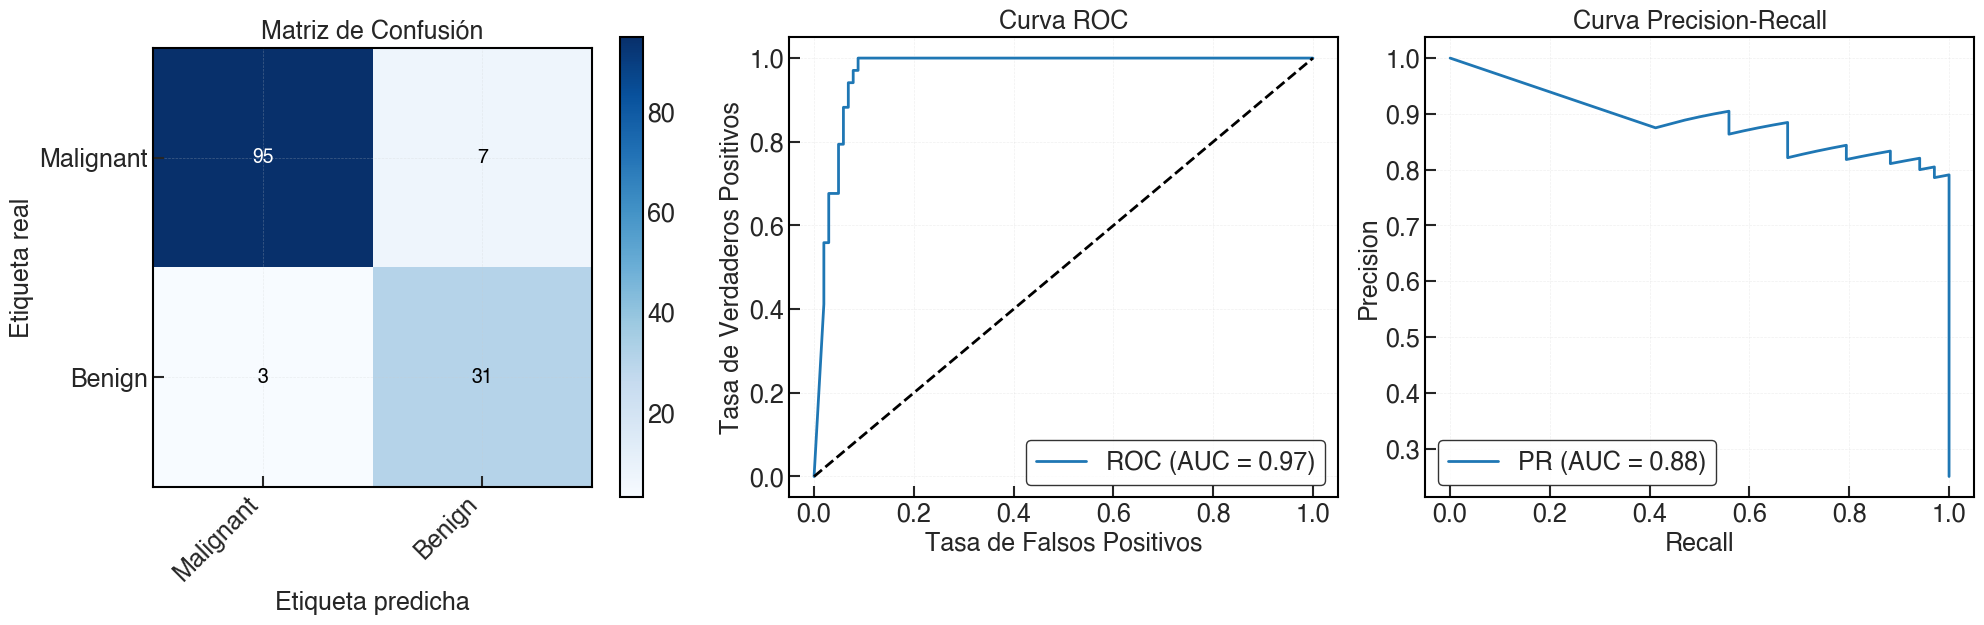

In [57]:

# Evaluar el modelo entrenado en el conjunto de validación
metrics_cost = evaluate_model(
    model=model_cost,
    X_test=X_test_cell_diagnosis_imbalanced,
    y_test=y_test_cell_diagnosis_imbalanced,
    class_names=class_names,
    show_plots=True,
    threshold=0.5,
    figsize=(20, 6),
    print_metrics=True
)


# Punto 2: Análisis del Dataset WAR_class

In [58]:
config_war_class = DatasetConfig(
    data_dir=data_dir_p2,
    target_column="war_class",
    split_config=SplitConfig(test_size=0.2, shuffle=True, random_state=42)
)
loader_war_class = DataLoader(config_war_class)
loader_war_class.read_data(
    dev_file="raw/WAR_class_dev.csv",
    test_file="raw/WAR_class_test.csv",
    splitted=False
)
war_class_dev, war_class_test = loader_war_class.get_pandas_data(splitted=False)

In [59]:
war_class_for_train, war_class_for_valid = train_valid_split(war_class_dev, test_size=0.2, random_state=42, stratify=war_class_dev["war_class"])
print("Valores nulos en conjunto de entrenamiento:")
print(war_class_for_train.isnull().sum().sum())
print("Valores nulos en conjunto de validación:")
print(war_class_for_valid.isnull().sum().sum())

Valores nulos en conjunto de entrenamiento:
0
Valores nulos en conjunto de validación:
0


In [60]:
print("WAR_class_train.csv - Información básica:")
print(f"Número de filas: {war_class_for_train.shape[0]}")
print(f"Número de columnas: {war_class_for_train.shape[1]}")
print("\nPrimeras filas del dataset:")
display(war_class_for_train.head())


WAR_class_train.csv - Información básica:
Número de filas: 5428
Número de columnas: 6

Primeras filas del dataset:


poss           mp  raptor_total  war_total  pace_impact  \
1783  5047.012726  2434.487850      3.458932   7.618132    -0.440176   
1804  5796.126175  3364.059145      0.970627   5.722426     0.088910   
1774  3853.197796  1531.003428     -0.857582   1.125958    -0.145478   
901   2867.611140  1406.844462     -1.277495   0.938911    -0.412709   
1634  1397.328381  1006.405608     -2.032124   0.062521    -0.273720   

      war_class  
1783          3  
1804          3  
1774          2  
901           2  
1634          2

In [61]:
analyze_null_values(
    [war_class_for_train, war_class_test],
    ["conjunto de entrenamiento WAR_class", "conjunto de prueba WAR_class"]
);

Valores nulos en conjunto de entrenamiento WAR_class:


Columna  Cantidad de nulos  Porcentaje (%)
0          poss                  0             0.0
1            mp                  0             0.0
2  raptor_total                  0             0.0
3     war_total                  0             0.0
4   pace_impact                  0             0.0
5     war_class                  0             0.0

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo         0             0.0
1           Muestras sin valores nulos      5428           100.0
2                    Total de muestras      5428           100.0



Valores nulos en conjunto de prueba WAR_class:


Columna  Cantidad de nulos  Porcentaje (%)
0          poss                  0             0.0
1            mp                  0             0.0
2  raptor_total                  0             0.0
3     war_total                  0             0.0
4   pace_impact                  0             0.0
5     war_class                  0             0.0

Métrica  Cantidad  Porcentaje (%)
0  Muestras con al menos un valor nulo         0             0.0
1           Muestras sin valores nulos      1696           100.0
2                    Total de muestras      1696           100.0

In [62]:
duplicated_rows = war_class_for_train.duplicated().sum()
print(f"Número de filas duplicadas en WAR_class_dev: {duplicated_rows}")

Número de filas duplicadas en WAR_class_dev: 0


In [63]:
analyze_categorical_variables(war_class_for_train, ["war_class"])

Distribución de variables categóricas:

Distribución de war_class:


war_class  Conteo  Porcentaje (%)
0          2    2008           36.99
1          3    1796           33.09
2          1    1624           29.92

In [64]:
numerical_cols_war = war_class_for_train.select_dtypes(include=["number"]).columns.tolist()
numerical_cols_war = [col for col in numerical_cols_war if col != "war_class"]

In [65]:
print("\nCaracterísticas principales:")
for col in numerical_cols_war:
    print(f"  {col}: {war_class_for_train[col].min():.2f} a {war_class_for_train[col].max():.2f} (promedio: {war_class_for_train[col].mean():.2f})")


Características principales:
  poss: -414.39 a 9329.40 (promedio: 3637.32)
  mp: -230.23 a 4264.46 (promedio: 1810.78)
  raptor_total: -29.83 a 20.13 (promedio: -1.47)
  war_total: -6.59 a 28.53 (promedio: 2.78)
  pace_impact: -6.74 a 11.19 (promedio: 0.09)


Se quitan valores negativos (los ponemos como NAN y usamos KNN para imputarlos)

In [66]:

numerical_cols_to_remove_negatives = ["poss", "mp", "war_total"]

war_class_for_train_outliers, neg_count_train = remove_negative_values(war_class_for_train, numerical_cols_to_remove_negatives)
war_class_for_valid_outliers, neg_count_valid = remove_negative_values(war_class_for_valid, numerical_cols_to_remove_negatives)
war_class_test, neg_count_test = remove_negative_values(war_class_test, numerical_cols_to_remove_negatives)


# Print results
print(f"Replaced {neg_count_train} negative values in training set")
print(f"Replaced {neg_count_valid} negative values in validation set")
print(f"Replaced {neg_count_test} negative values in test set")


Replaced 2530 negative values in training set
Replaced 635 negative values in validation set
Replaced 773 negative values in test set


In [67]:



X_train_war_class_for_cross_validation = war_class_for_train.drop(columns=["war_class","war_total"]) #no hacemos data leakage porque es una transformación determinista basada en reglas que no aprende ni utiliza estadísticas del conjunto de datos
y_train_war_class_for_cross_validation = war_class_for_train["war_class"].to_numpy()

# Now impute missing values
war_class_for_train, war_class_for_valid, war_class_test = impute_missing_values(
    war_class_for_train_outliers,
    war_class_for_valid_outliers,
    war_class_test,
    knn_neighbors=5,
    knn_weights="distance"
)



Missing values before imputation:
Train: 2530 missing values
Valid: 635 missing values
Test: 773 missing values

Missing values after imputation:
Train: 0 missing values
Valid: 0 missing values
Test: 0 missing values


In [68]:
print("\nCaracterísticas principales:")
for col in numerical_cols_war:
    print(f"  {col}: {war_class_for_train[col].min():.2f} a {war_class_for_train[col].max():.2f} (promedio: {war_class_for_train[col].mean():.2f})")


Características principales:
  poss: 4.24 a 9329.40 (promedio: 3646.67)
  mp: 0.23 a 4264.46 (promedio: 1815.87)
  raptor_total: -29.83 a 20.13 (promedio: -1.47)
  war_total: 0.00 a 28.53 (promedio: 5.93)
  pace_impact: -6.74 a 11.19 (promedio: 0.09)


Gráfico guardado en: ../figures/p2/numerical_distributions_outliers.png


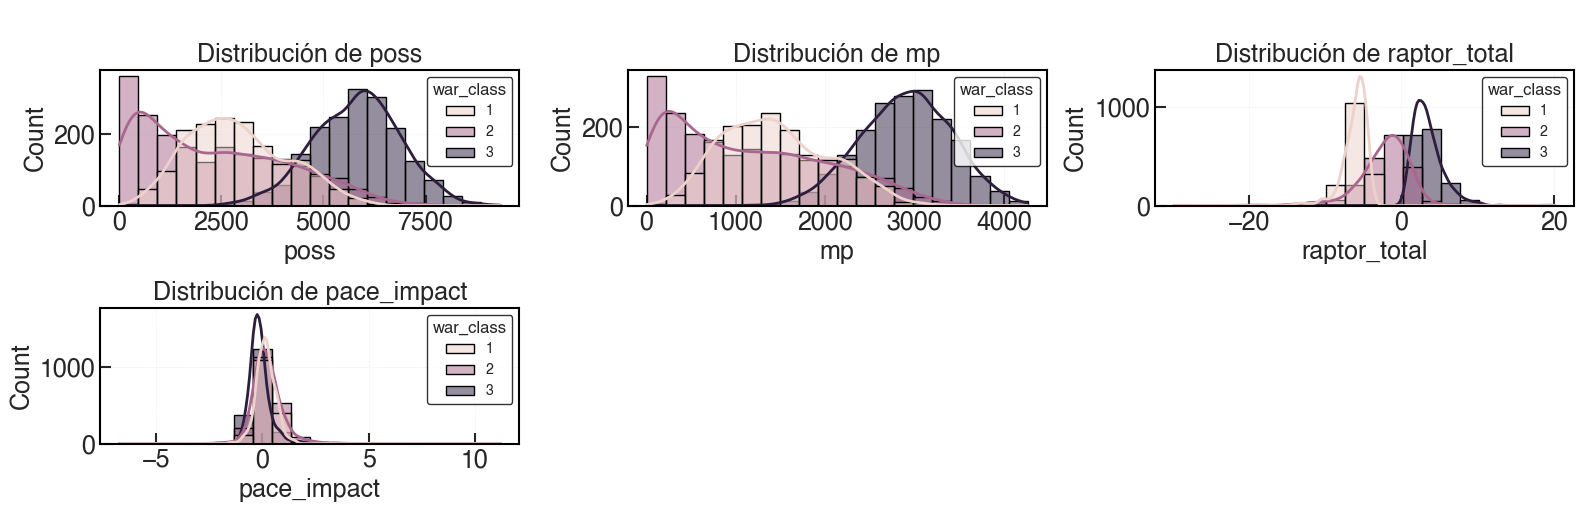

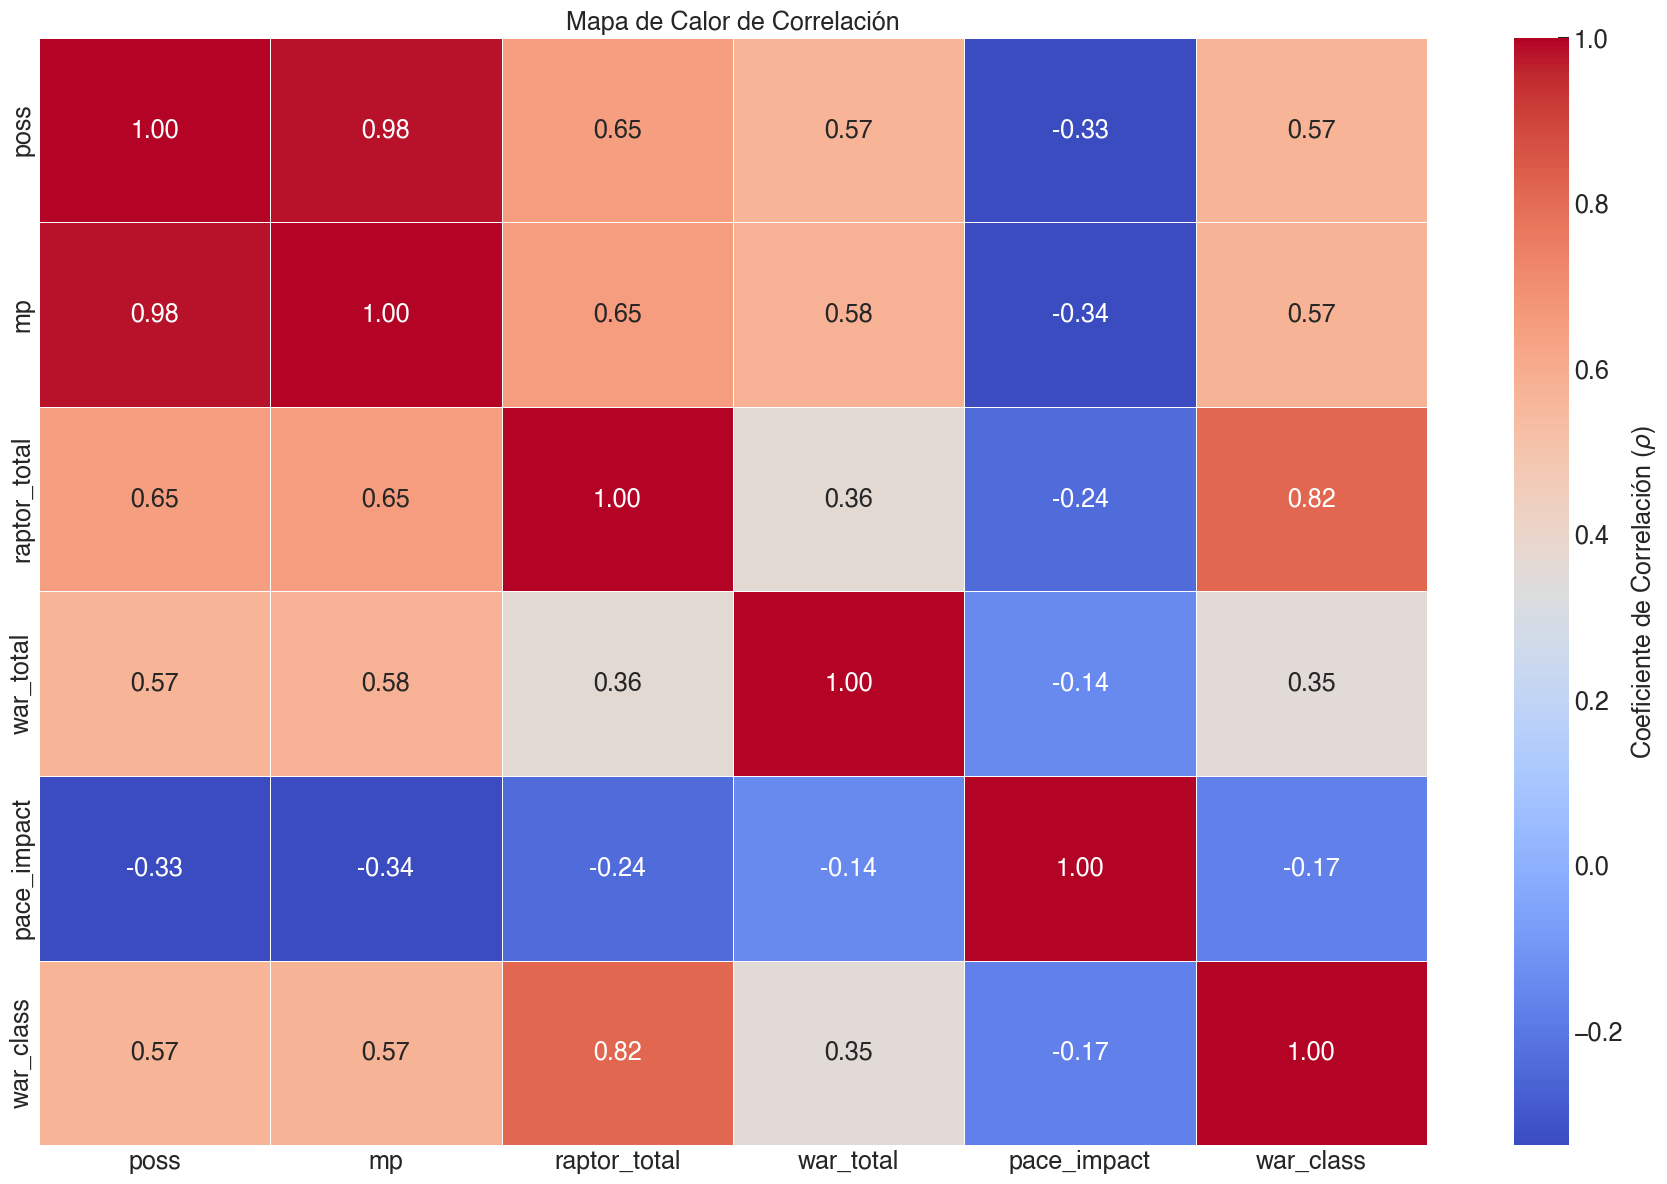

Gráfico guardado en: ../figures/p2/boxplots_outliers_analysis.png


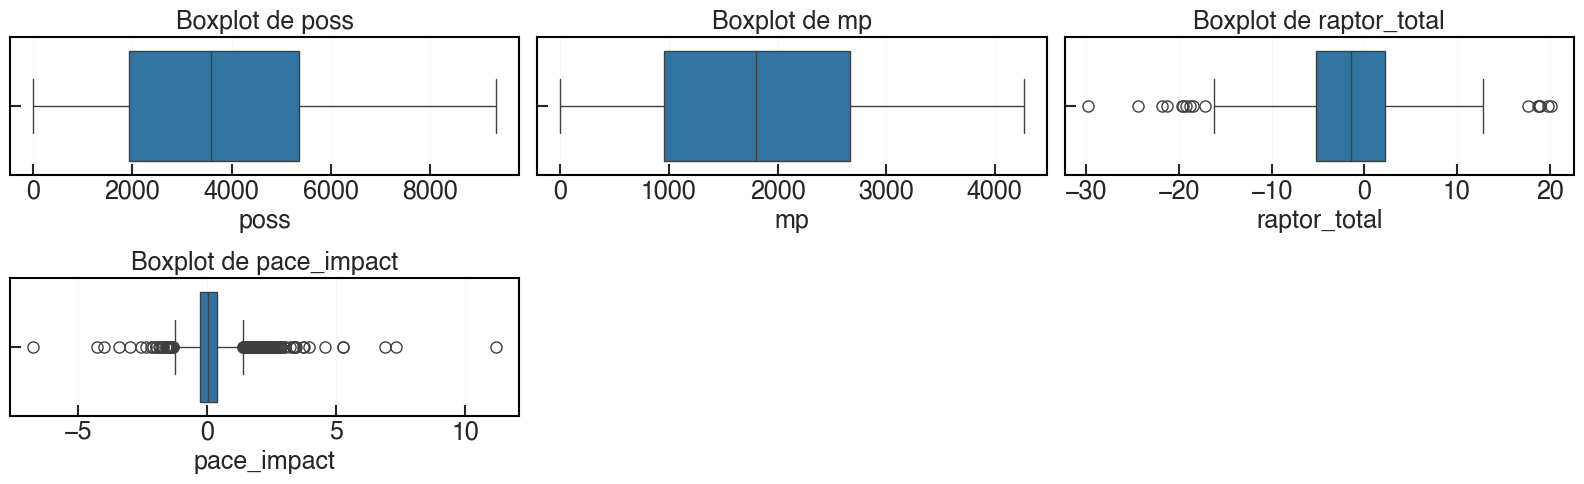

In [69]:

FEATURES_TO_PLOT_WAR = ["poss", "mp", "raptor_total", "pace_impact"]

fig_params ={
    "heatmap_params":{
        "label_fontsize":18,
        "title_fontsize":18,
        "tick_fontsize":18,
        "cbar_fontsize":18,
        "annot_fontsize":18,
        # "correlation_method":"pearson",
        "figsize":(18,12)
    },
    "outliers_params":{
        "method":"iqr",
        "target_column":"war_class",
        "return_params":True,
        "figsize":(16,10)
    },
    "numerical_distributions_params":{
        "figsize":(16,5)
    }
}

plot_data_analysis_all_visualizations(
    war_class_for_train,
    numerical_cols_war,
    "war_class",
    FEATURES_TO_PLOT_WAR,
    fig_output_dir_p2,
    fig_output_dir_p2,
    fig_params
);


In [70]:
war_class_for_train, war_iqr_params = replace_outliers_iqr(war_class_for_train, method="winsorize", target_column="war_class",return_params=True)
war_class_for_valid = replace_outliers_iqr(war_class_for_valid, method="winsorize", params=war_iqr_params, target_column="war_class")
war_class_test = replace_outliers_iqr(war_class_test, method="winsorize", params=war_iqr_params, target_column="war_class")




loader_war_class.update(
    df_train=war_class_for_train,
    df_valid=war_class_for_valid,
    df_test=war_class_test
);


In [71]:

data_dict = {
    "df_train":war_class_for_train,
    "df_valid":war_class_for_valid,
    "df_test":war_class_test
}

save_processed_data(
    data_dict=data_dict,
    data_dir=data_dir_p2,
    loader=loader_war_class,
    dataset_name="WAR_class"
)

In [72]:
loader_war_class.read_data(
    train_file="preprocessed/WAR_class_train.csv",
    valid_file="preprocessed/WAR_class_valid.csv",
    test_file="preprocessed/WAR_class_test.csv",
    splitted=True
)
war_class_for_train, war_class_for_valid, war_class_test = loader_war_class.get_pandas_data(splitted=True)

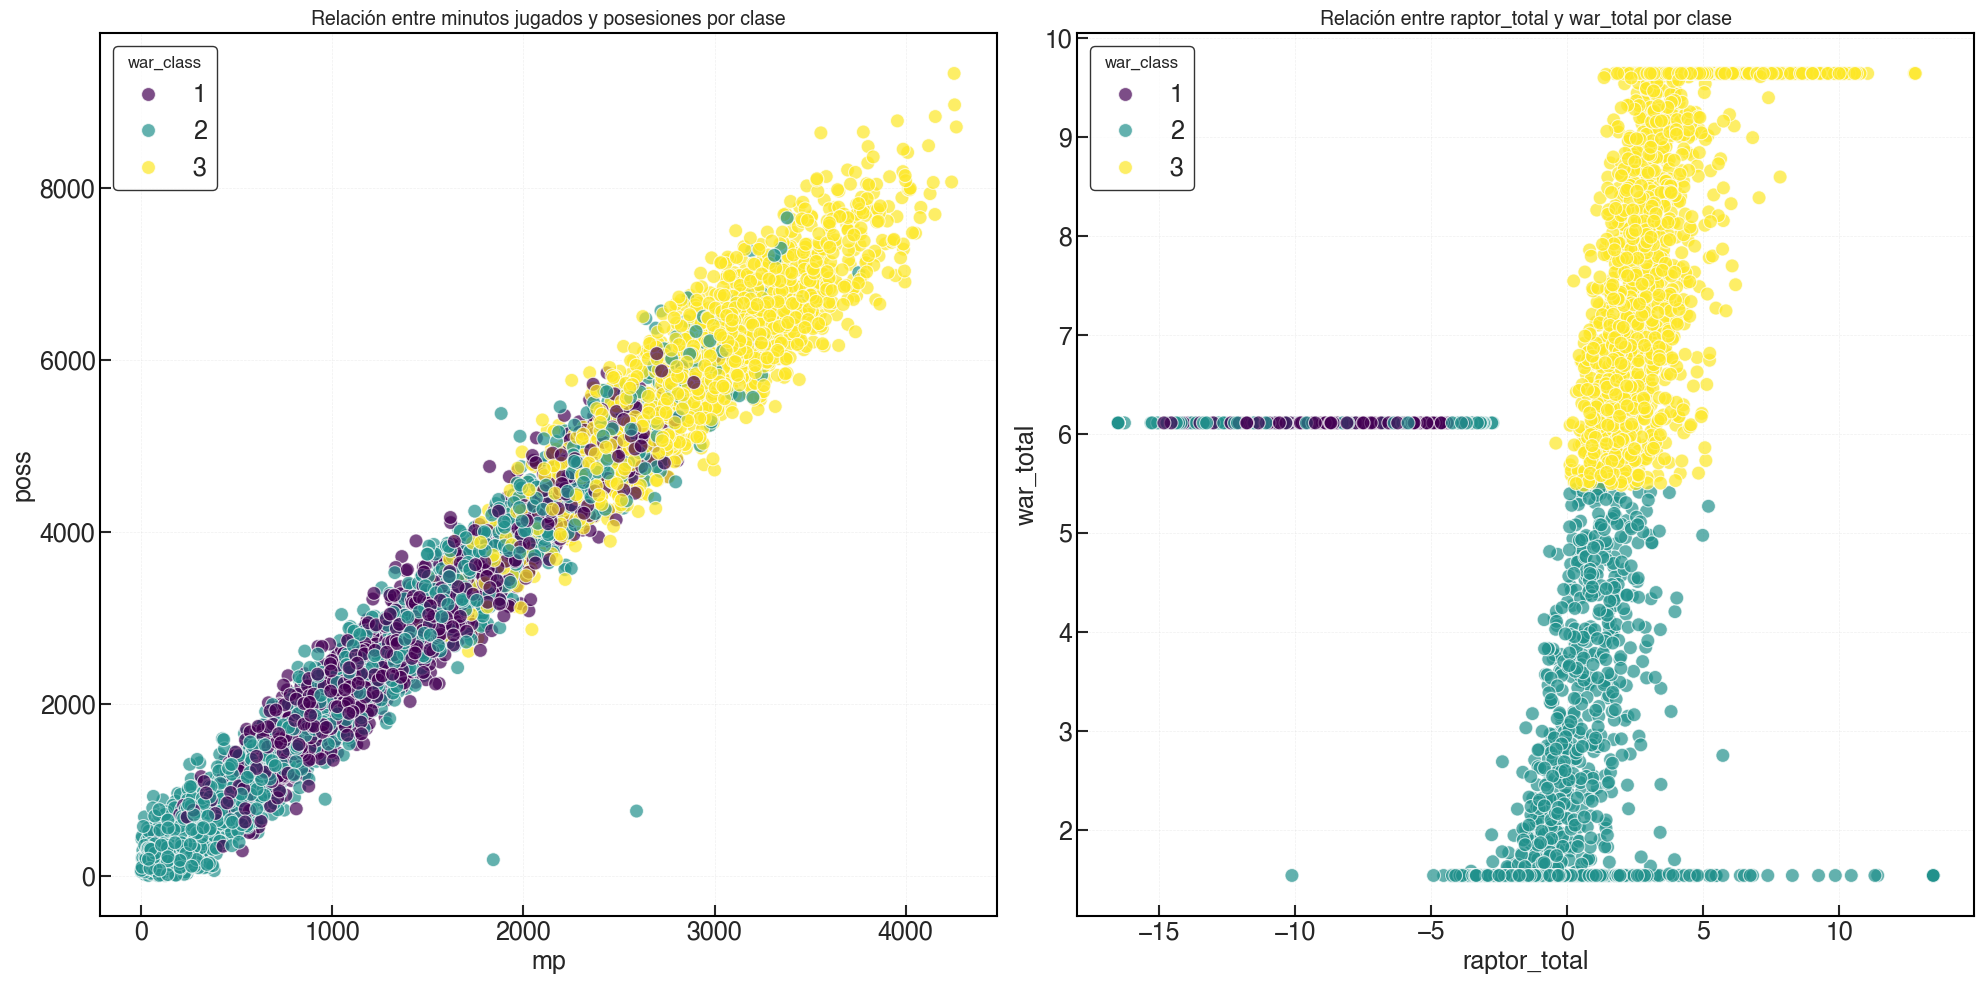

In [73]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

sns.scatterplot(data=war_class_for_train, x="mp", y="poss", hue="war_class", palette="viridis", s=100, alpha=0.7, ax=axes[0])
axes[0].set_title("Relación entre minutos jugados y posesiones por clase", fontsize=14)
axes[0].grid(True, alpha=0.3)

sns.scatterplot(data=war_class_for_train, x="raptor_total", y="war_total", hue="war_class", palette="viridis", s=100, alpha=0.7, ax=axes[1])
axes[1].set_title("Relación entre raptor_total y war_total por clase", fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(fig_output_dir_p2, "scatter_relationships.png"), dpi=300, bbox_inches="tight")
plt.show()

## Punto 2.2

In [74]:

X_train, y_train, X_valid, y_valid = process_training_data(war_class_for_train, war_class_for_valid, "war_class",encode_categorical=False)

X_test, y_test = loader_war_class.get_processed_test_data(
    encode_categorical=False,
    normalize=False
)

X_test = war_class_test.drop(columns=["war_class","war_total"]).to_numpy()
y_test = war_class_test["war_class"].to_numpy()


In [75]:
X_train_normalized, params = normalize_data(X_train, None, return_params=True)
X_valid_normalized = normalize_data(X_valid, params)
X_test_normalized = normalize_data(X_test, params)

In [76]:
from models.random_forest import RandomForest, RandomForestConfig
from models.lda import LDA, LDAConfig

# Punto 2.3


Accuracy: 0.9232
Precision: 0.9322
Recall: 0.9232
F1 Score: 0.9215


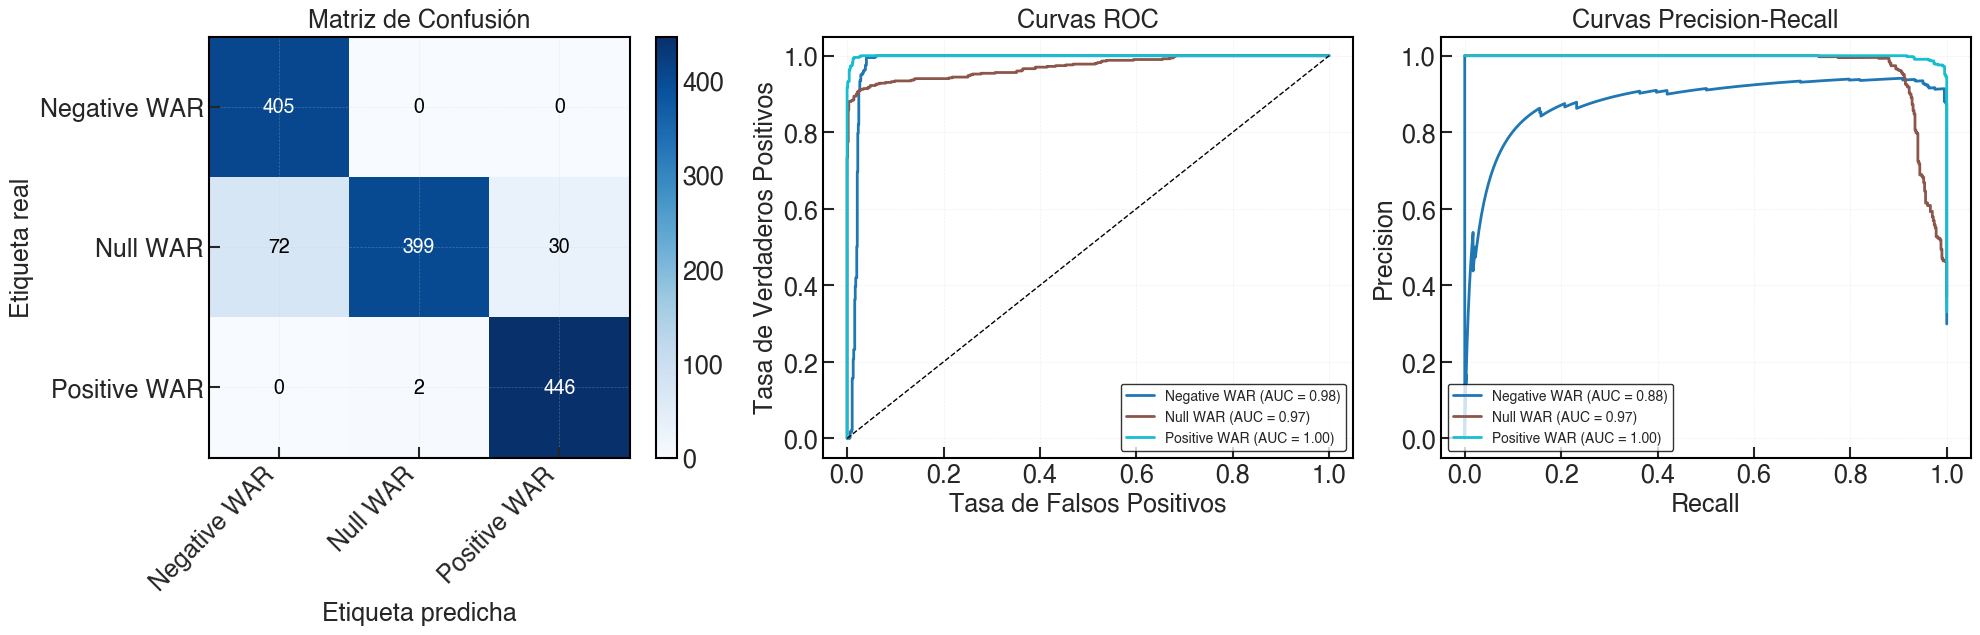

In [77]:

lda_config = LDAConfig(solver="svd")
lda_model = LDA(lda_config)
lda_model.fit(X_train_normalized, y_train)




evaluate_model(
    model=lda_model,
    X_test=X_valid_normalized,
    y_test=y_valid,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],  
    save_dir=fig_output_dir_p2,
    base_filename="lda",
    figsize=(20, 6)
);






Gráfico guardado en: ../figures/p2/lambda_tuning_multiclass_logistic_regression


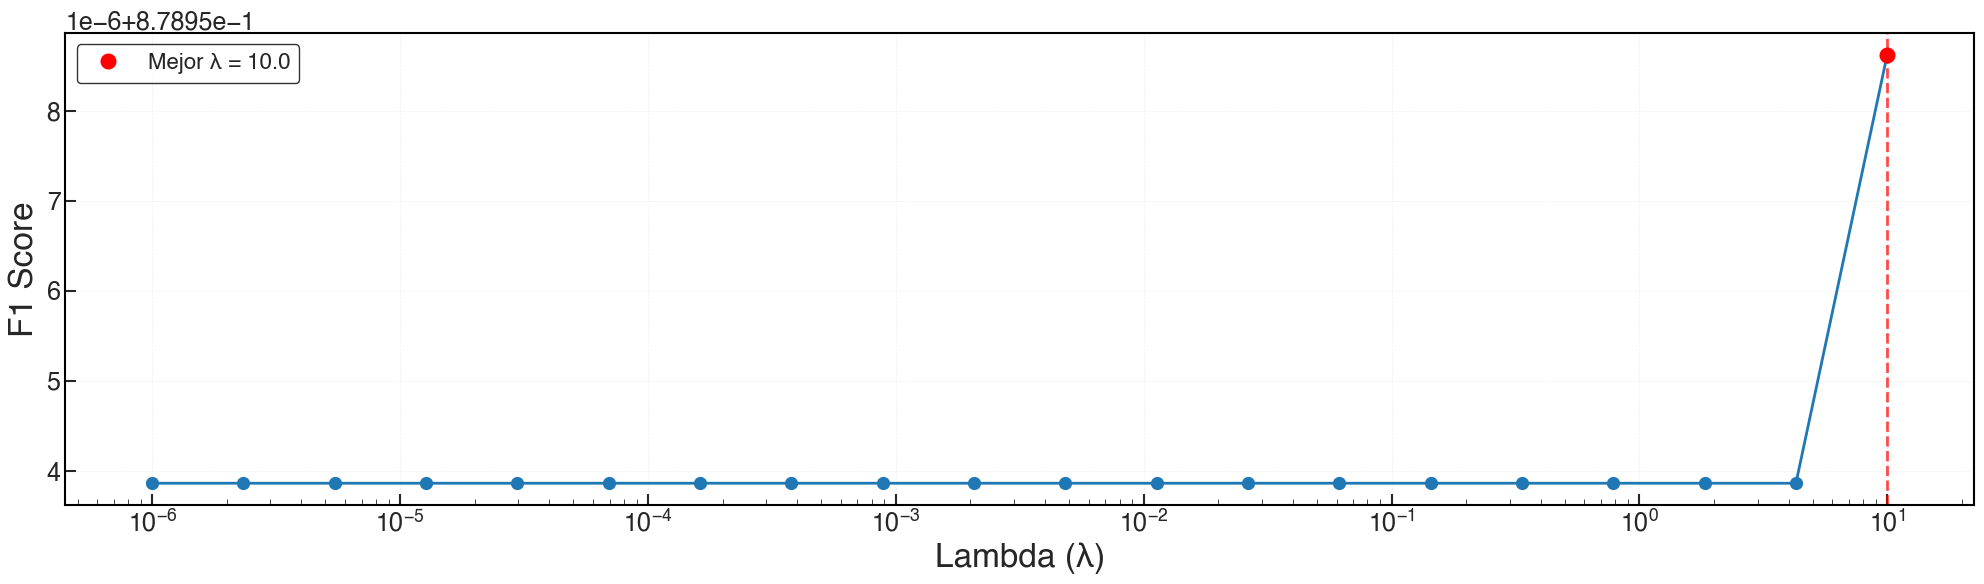

In [78]:


best_lambda_multiclass_logistic_regression, cv_scores = cross_validate_lambda(
    X=X_train_war_class_for_cross_validation,
    y=y_train_war_class_for_cross_validation,
    lambda_values=lambda_values,
    categorical_columns=[],
    metric_fn=f1_score,
    k_folds=5,
    average="weighted",
    verbose=False,
    stratified=True,
    threshold=0.5,
    normalize=True,
    aggregate_predictions=True,
    resampler=None
)

plot_lambda_tuning(lambda_values, cv_scores, metric_name="F1 Score", save_dir=fig_output_dir_p2, filename="lambda_tuning_multiclass_logistic_regression", best_lambda=best_lambda_multiclass_logistic_regression, figsize=(20, 6), dpi=300)


Accuracy: 0.6041
Precision: 0.4218
Recall: 0.6041
F1 Score: 0.4965


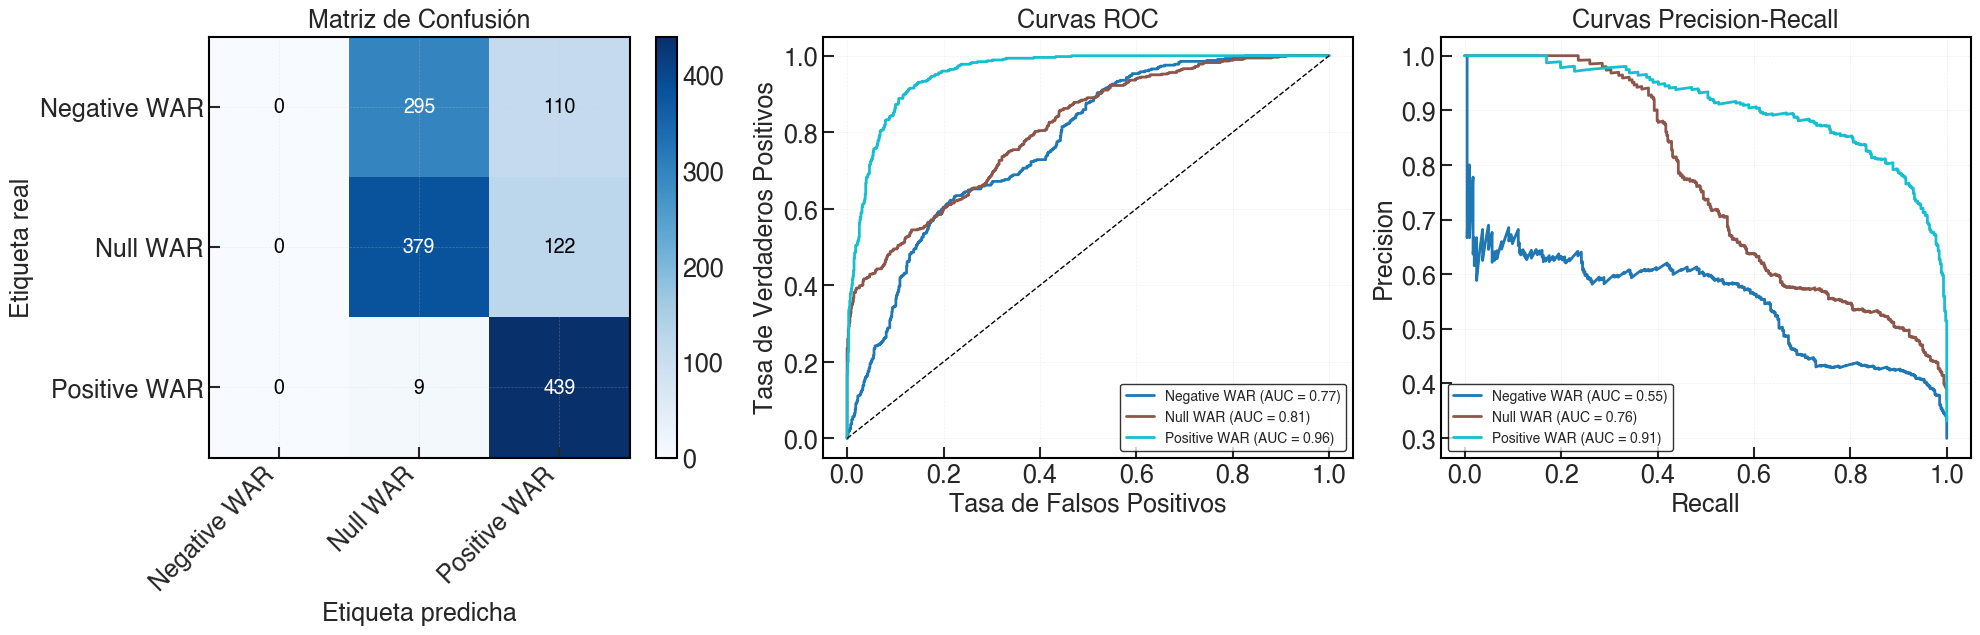

In [79]:

multiclass_logistic_regression_config = LogisticRegressionConfig(
    lambda_reg=best_lambda_multiclass_logistic_regression,
    max_iter=1000,
    tol=1e-4,
    learning_rate=0.01
)


model_multiclass_logistic_regression = LogisticRegression(multiclass_logistic_regression_config)

model_multiclass_logistic_regression.fit(X_train_normalized, y_train)

result_multiclass_logistic_regression = evaluate_model(
    model=model_multiclass_logistic_regression,
    X_test=X_valid_normalized,
    y_test=y_valid,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="multiclass_logistic_regression",
    figsize=(20, 6),
    average="weighted"
)

Accuracy: 0.9845
Precision: 0.9847
Recall: 0.9845
F1 Score: 0.9845


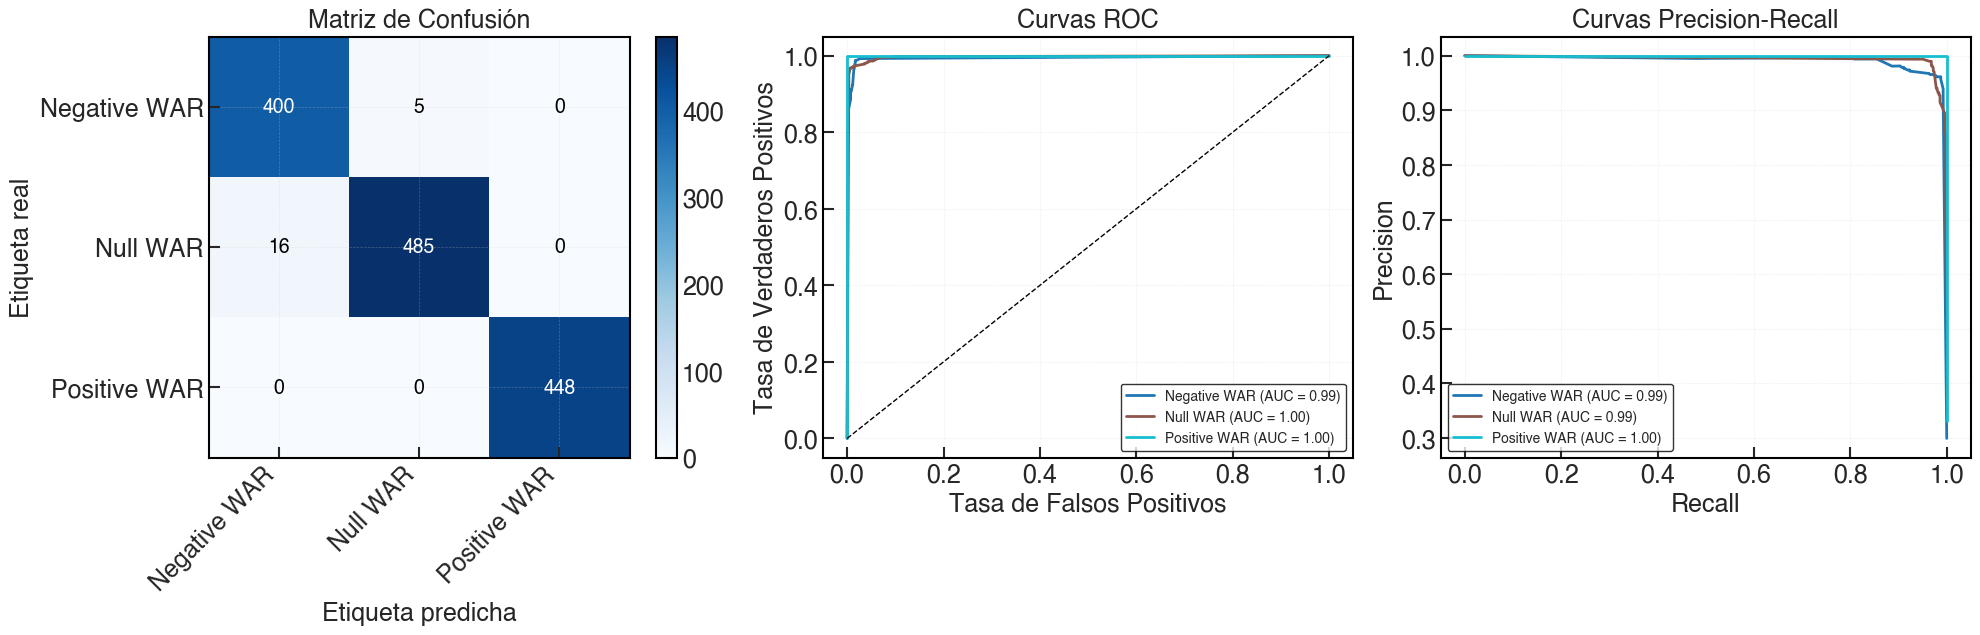

In [80]:
random_forest_config = RandomForestConfig(
    n_estimators=3,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    criterion="entropy"
)

model_random_forest = RandomForest(random_forest_config)

model_random_forest.fit(X_train, y_train)


result_random_forest = evaluate_model(
    model=model_random_forest,
    X_test=X_valid,
    y_test=y_valid,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="random_forest",
    figsize=(20, 6),
    average="weighted"
)




## Punto 2.4: entrenando en dev

In [81]:
# Combine training and validation sets



war_class_dev, neg_count_war_class_dev = remove_negative_values(war_class_dev, numerical_cols_to_remove_negatives)

X_train_war_class_for_cross_validation = war_class_dev.drop(columns=["war_class","war_total"])
y_train_war_class_for_cross_validation = war_class_dev["war_class"].to_numpy()


In [82]:

war_class_dev = impute_missing_values(
    war_class_dev,
    knn_neighbors=5,
    knn_weights="distance"
)


war_class_dev = replace_outliers_iqr(
    war_class_dev,
    method="iqr",
    target_column="war_class"
)


X_train_war_class_dev, y_train_war_class_dev = war_class_dev.drop(columns=["war_class","war_total"]), war_class_dev["war_class"]

X_test, y_test = war_class_test.drop(columns=["war_class","war_total"]), war_class_test["war_class"]




X_train_full_dev_normalized, params = normalize_data(X_train_war_class_dev, None, return_params=True)
X_test_full_dev_normalized = normalize_data(X_test, params)
y_test_full_dev = y_test

X_test_full_dev_normalized = X_test_full_dev_normalized.to_numpy()
X_train_full_dev_normalized = X_train_full_dev_normalized.to_numpy()
y_test_full_dev = y_test_full_dev.to_numpy()
y_train_war_class_dev = y_train_war_class_dev.to_numpy()


Missing values before imputation:
Train: 3165 missing values

Missing values after imputation:
Train: 0 missing values


Gráfico guardado en: ../figures/p2/numerical_distributions_outliers.png


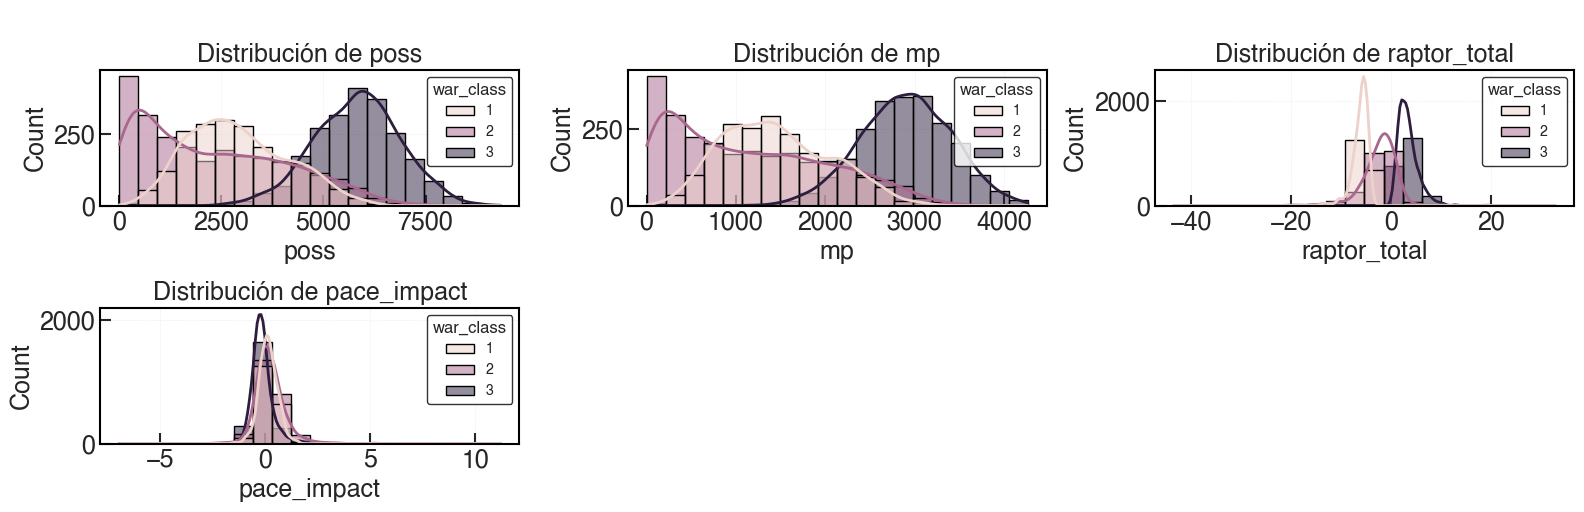

Gráfico guardado en: ../figures/p2/correlation_heatmap_numerical_features_outliers.png


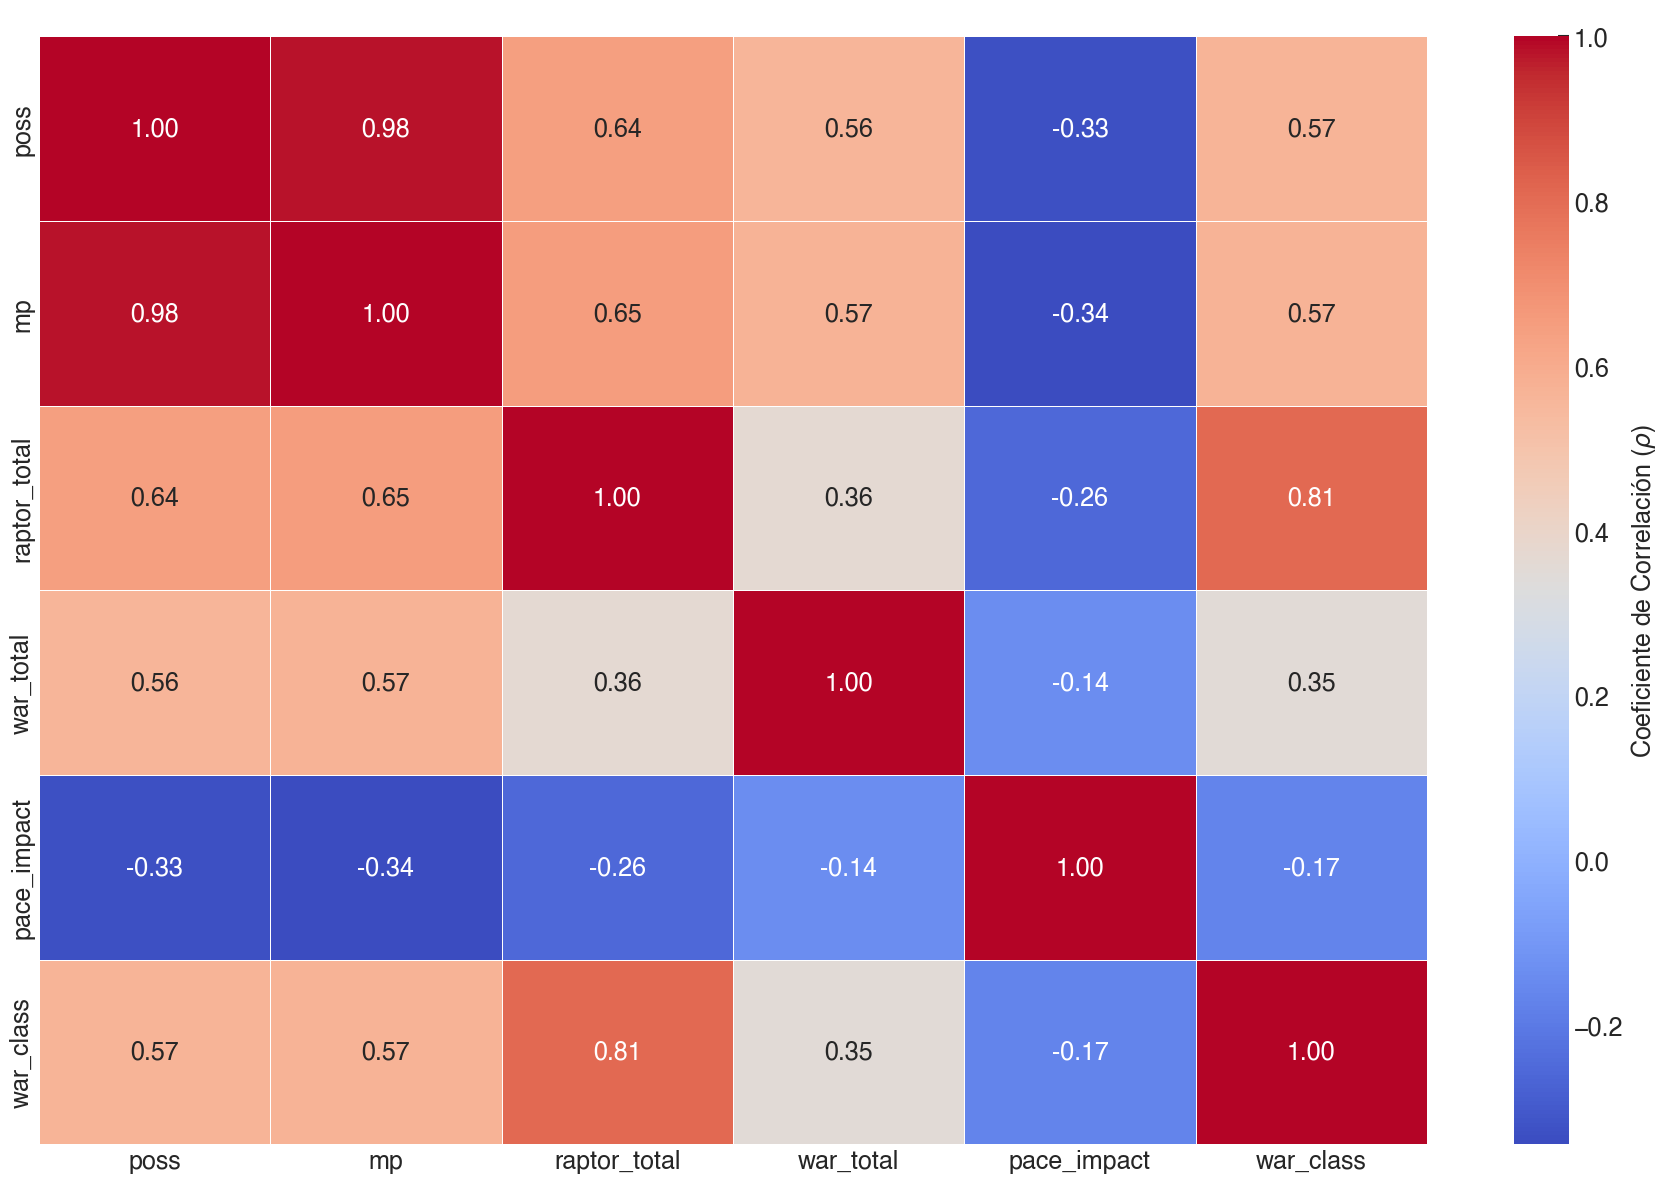

Gráfico guardado en: ../figures/p2/boxplots_outliers_analysis.png


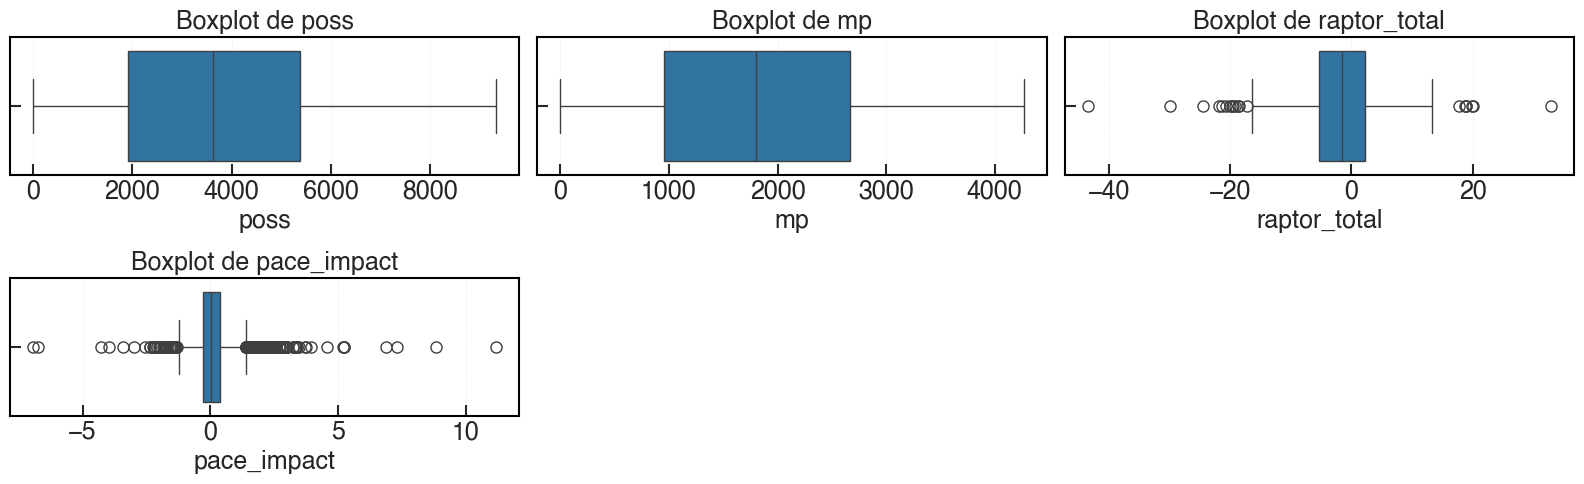

In [83]:
plot_data_analysis_all_visualizations(
    war_class_dev,
    numerical_cols_war,
    "war_class",
    FEATURES_TO_PLOT_WAR,
    fig_output_dir_p2,
    fig_output_dir_p2
);

Accuracy: 0.9051
Precision: 0.9145
Recall: 0.9051
F1 Score: 0.9020


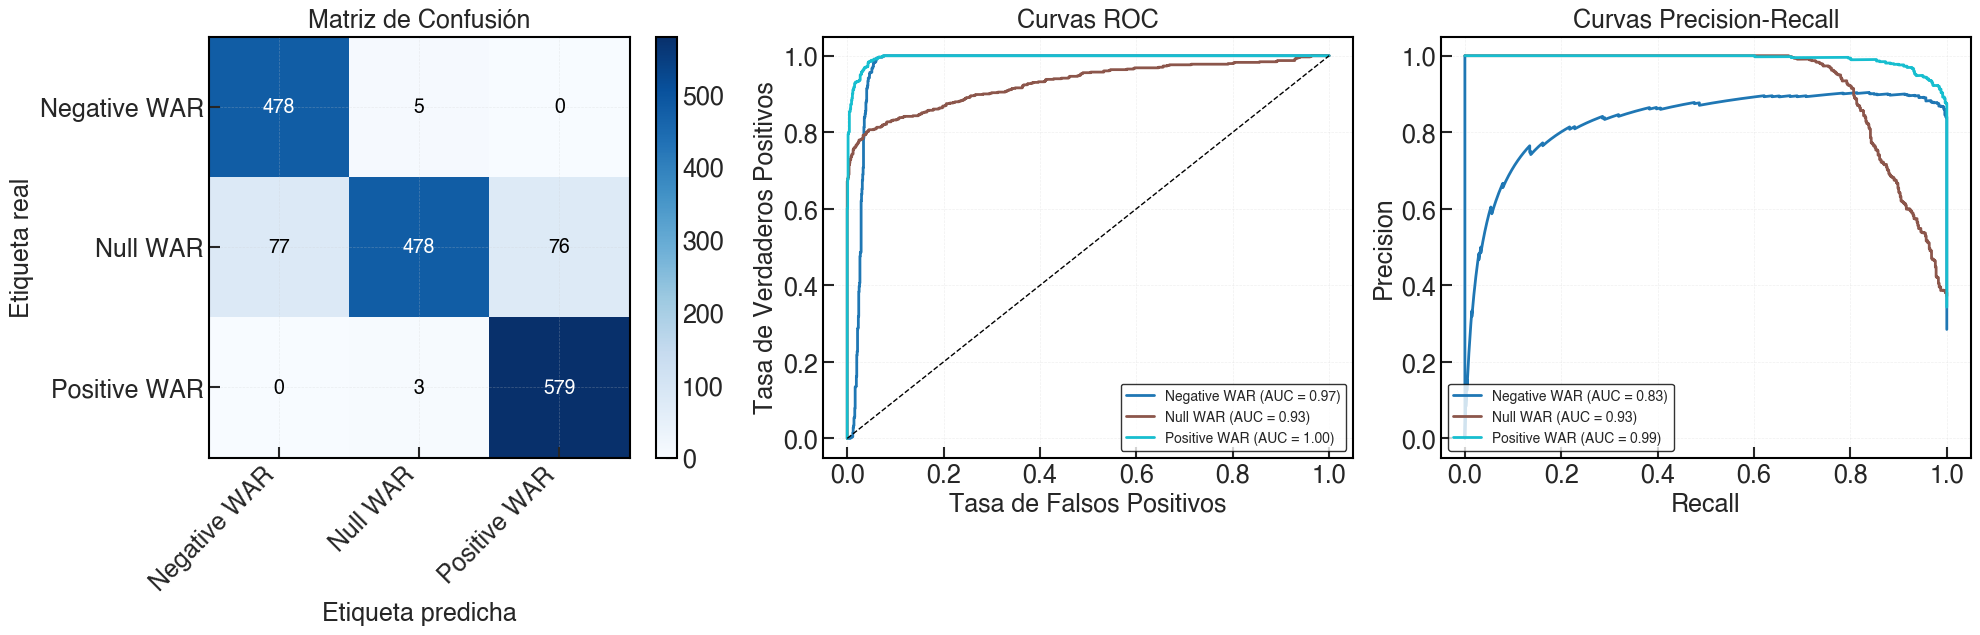

In [84]:

lda_config = LDAConfig(solver="svd")
lda_model = LDA(lda_config)
lda_model.fit(X_train_full_dev_normalized, y_train_war_class_dev)



evaluate_model(
    model=lda_model,
    X_test=X_test_full_dev_normalized,
    y_test=y_test_full_dev,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],  # Real class names
    save_dir=fig_output_dir_p2,
    base_filename="lda",
    figsize=(20, 6)
);






Accuracy: 0.8874
Precision: 0.8956
Recall: 0.8874
F1 Score: 0.8836


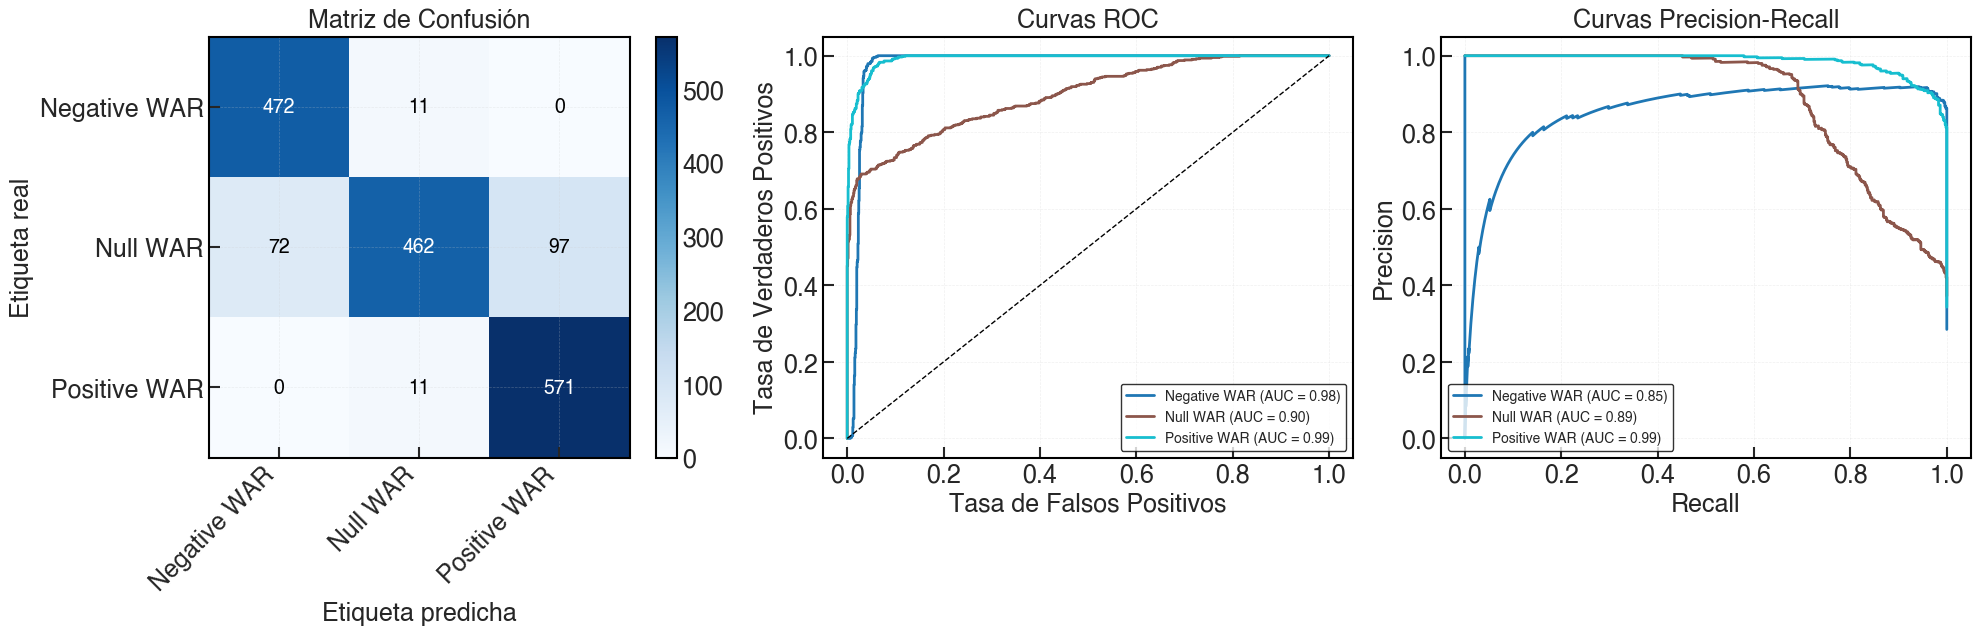

In [85]:




best_lambda_multiclass_logistic_regression, cv_scores = cross_validate_lambda(
    X=X_train_war_class_for_cross_validation,
    y=y_train_war_class_for_cross_validation,
    lambda_values=lambda_values,
    metric_fn=f1_score,
    stratified=True,
    normalize=True,
    k_folds=5,
    average="weighted",
    verbose=False,
    threshold=0.5,
    aggregate_predictions=True,
    resampler=None
)


multiclass_logistic_regression_config = LogisticRegressionConfig(
    lambda_reg=best_lambda_multiclass_logistic_regression,
    max_iter=1000,
    tol=1e-4,
    learning_rate=0.01
)


model_multiclass_logistic_regression = LogisticRegression(multiclass_logistic_regression_config)

model_multiclass_logistic_regression.fit(X_train_full_dev_normalized, y_train_war_class_dev)

result_multiclass_logistic_regression = evaluate_model(
    model=model_multiclass_logistic_regression,
    X_test=X_test_full_dev_normalized,
    y_test=y_test_full_dev,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="multiclass_logistic_regression",
    figsize=(20, 6),
    average="weighted"
)

Accuracy: 0.9581
Precision: 0.9581
Recall: 0.9581
F1 Score: 0.9580


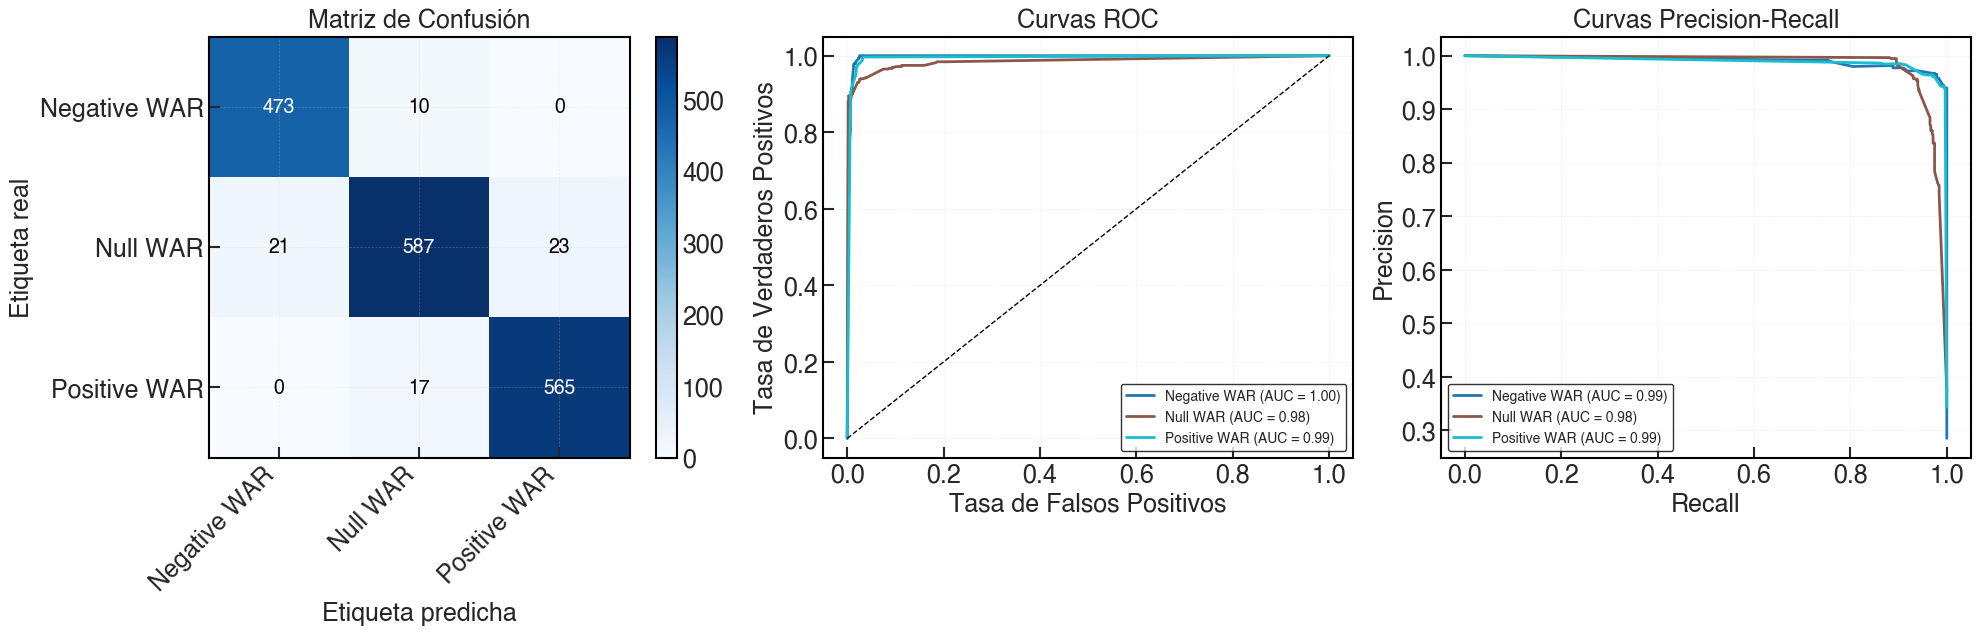

In [86]:
# print shapes


random_forest_config = RandomForestConfig(
    n_estimators=3,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    criterion="entropy"
)

model_random_forest = RandomForest(random_forest_config)

model_random_forest.fit(X_train_full_dev_normalized, y_train_war_class_dev)

result_random_forest = evaluate_model(
    model=model_random_forest,
    X_test=X_test_full_dev_normalized,
    y_test=y_test_full_dev,
    class_names=["Negative WAR", "Null WAR", "Positive WAR"],
    save_dir=fig_output_dir_p2,
    base_filename="random_forest",
    figsize=(20, 6),
    average="weighted"
)



